<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/tps/1c2024/Practica_10_completa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clase 9: Selección de Modelos de Regresión

En esta clase vamos a ver cómo cargar modelos de regresión en `Bambi`, y luego como evaluar los modelos y seleccionar el "mejor".

Empecemos importando las librerías necesarias.

In [ ]:
# Instalación e import de Bambi
try:
  import bambi as bmb
except:
  !pip install bambi
  import bambi as bmb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pandas as pd
import io

## Ejemplo: Período Natural de Galpones Metálicos

Tomemos como proyecto encontrar una ecuación que explique el período natural de los galpones metálicos.

### Carga de Datos

In [ ]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
from google.colab import files
uploaded = files.upload()

Saving Galpones_v2.csv to Galpones_v2.csv


In [ ]:
#Se crea un DataFrame
df = pd.read_csv(io.BytesIO(uploaded['Galpones_v2.csv']))
df

Frame  W_kip_  Height_in_  L_ft_  alpha      Cladding   Structure  \
0        1   10.21       190.0     40  2.526  Metal Panels  Clear Span   
1        2   25.16       192.5    100  6.234  Metal Panels  Clear Span   
2        3   46.71       220.0    160  8.727  Metal Panels  Clear Span   
3        4   13.14       400.0     40  1.200  Metal Panels  Clear Span   
4        5   52.23       385.0    100  3.117  Metal Panels  Clear Span   
..     ...     ...         ...    ...    ...           ...         ...   
187    188  147.07       435.0    300  1.920      Concrete     Modular   
188    189  111.54       560.0     80  0.873      Concrete     Modular   
189    190  155.92       600.0    120  1.263      Concrete     Modular   
190    191  143.16       570.0    240  0.873      Concrete     Modular   
191    192  174.46       615.0    300  1.297      Concrete     Modular   

          Roof  Snow_psf Seismic  Wind   Weights  k_lat_kip_ft_  \
0    Monoslope         0     Low  High  0.011666          3.520   
1       Gabled         0     Low  High  0.032986         12.459   
2    Monoslope         0    High  High  0.001667         27.663   
3       Gabled         0     Low  High  0.002174          3.563   
4    Monoslope        42    High   Low  0.001058          7.218   
..         ...       ...     ...   ...       ...            ...   
187  Monoslope         0    High   Low  0.000047         19.938   
188  Monoslope         0     Low  High  0.000067          3.223   
189  Monoslope        42     Low  High  0.000009          4.280   
190     Gabled         0     Low   Low  0.000132          1.566   
191  Monoslope         0    High  High  0.000005         13.304   

     MassParticipation  T_model_s_  T_r1_s_  T_r2_s_  T_S_U_s_  
0                0.933       0.546    0.546    0.545  0.707386  
1                0.619       0.571    0.560    0.454  0.537498  
2                0.423       0.606    0.580    0.415  0.423907  
3                0.930       0.602    0.602    0.614  0.953937  
4                0.925       0.881    0.880    0.860  1.208260  
..                 ...         ...      ...      ...       ...  
187              0.945       0.884    0.881    0.868  2.018956  
188              0.982       1.876    1.876    1.881  2.004511  
189              0.969       1.938    1.938    1.930  2.262762  
190              0.991       3.051    3.051    3.057  2.171860  
191              0.960       1.158    1.156    1.158  2.357730  

[192 rows x 18 columns]

Nuestro objetivo es predecir el período natural (`T_model_s`) En función de variables predictoras, tanto categóricas como continuas.

A veces las variables categóricas están escritas como números (Por ejemplo, la carga de nieve en este caso). Para trabajar en `Bambi`, es recomendable indicar claramente las variables a considerar como categóricas modificando el `type` en pandas.

NOTA: ¡Las categóricas pueden también ser ordinales, pero eso queda para una próxima clase!

In [ ]:
df.dtypes

Frame                  int64
W_kip_               float64
Height_in_           float64
L_ft_                  int64
alpha                float64
Cladding              object
Structure             object
Roof                  object
Snow_psf               int64
Seismic               object
Wind                  object
Weights              float64
k_lat_kip_ft_        float64
MassParticipation    float64
T_model_s_           float64
T_r1_s_              float64
T_r2_s_              float64
T_S_U_s_             float64
dtype: object

In [ ]:
# Modificar variables a Categóricas
df['Cladding'] = df['Cladding'].astype('category')
df['Structure'] = df['Structure'].astype('category')
df['Roof'] = df['Roof'].astype('category')
df['Snow_psf'] = df['Snow_psf'].astype('category')
df['Seismic'] = df['Seismic'].astype('category')
df['Wind'] = df['Wind'].astype('category')

df.head()

Frame  W_kip_  Height_in_  L_ft_  alpha      Cladding   Structure  \
0      1   10.21       190.0     40  2.526  Metal Panels  Clear Span   
1      2   25.16       192.5    100  6.234  Metal Panels  Clear Span   
2      3   46.71       220.0    160  8.727  Metal Panels  Clear Span   
3      4   13.14       400.0     40  1.200  Metal Panels  Clear Span   
4      5   52.23       385.0    100  3.117  Metal Panels  Clear Span   

        Roof Snow_psf Seismic  Wind   Weights  k_lat_kip_ft_  \
0  Monoslope        0     Low  High  0.011666          3.520   
1     Gabled        0     Low  High  0.032986         12.459   
2  Monoslope        0    High  High  0.001667         27.663   
3     Gabled        0     Low  High  0.002174          3.563   
4  Monoslope       42    High   Low  0.001058          7.218   

   MassParticipation  T_model_s_  T_r1_s_  T_r2_s_  T_S_U_s_  
0              0.933       0.546    0.546    0.545  0.707386  
1              0.619       0.571    0.560    0.454  0.537498  
2              0.423       0.606    0.580    0.415  0.423907  
3              0.930       0.602    0.602    0.614  0.953937  
4              0.925       0.881    0.880    0.860  1.208260

In [ ]:
df.dtypes

Frame                   int64
W_kip_                float64
Height_in_            float64
L_ft_                   int64
alpha                 float64
Cladding             category
Structure            category
Roof                 category
Snow_psf             category
Seismic              category
Wind                 category
Weights               float64
k_lat_kip_ft_         float64
MassParticipation     float64
T_model_s_            float64
T_r1_s_               float64
T_r2_s_               float64
T_S_U_s_              float64
dtype: object

Si bien `Bambi` puede ser suficientemente inteligente para reconocer variables categóricas (por ejemplo, todo aquello cuyos nombres son texto, o según cómo se indica en la fórmula), lo recomendable es hacerlo explícito en dataframe como hicimos arriba.

Abajo pueden ver un muy reducido (y muy pobre) análisis de datos, como para poder jugar con el ejercicio.

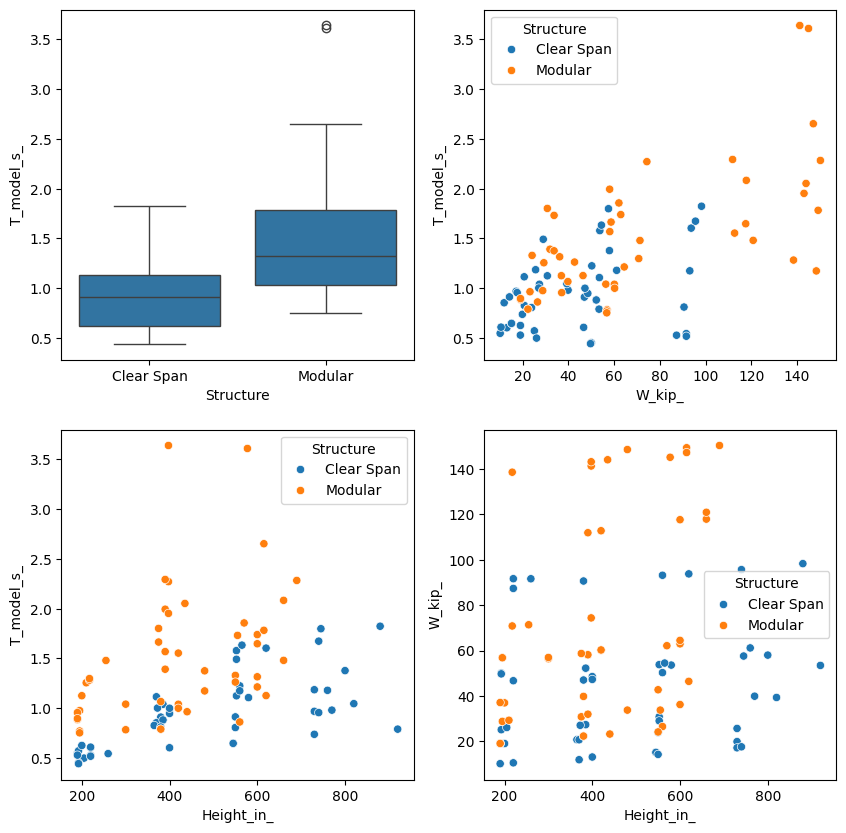

In [ ]:
fig, (axs) = plt.subplots(2, 2,figsize=(10,10))
sns.boxplot(x='Structure', y='T_model_s_', data=df[df['Cladding']=='Metal Panels'],ax=axs[0,0])
sns.scatterplot(x='W_kip_', y='T_model_s_', hue='Structure',data=df[df['Cladding']=='Metal Panels'],ax=axs[0,1])
sns.scatterplot(x='Height_in_', y='T_model_s_', hue='Structure',data=df[df['Cladding']=='Metal Panels'],ax=axs[1,0])
sns.scatterplot(x='Height_in_', y='W_kip_', hue='Structure',data=df[df['Cladding']=='Metal Panels'],ax=axs[1,1])
plt.show()

### Modelo 1: Regresión con predictor categórico

A lo largo de este ejercicio vamos a analizar los Galpones Metálicos con cerramiento de chapa (`Cladding = Metal Panels`).

Basado de un rápido analísis preliminar, se detectó que la tipología estructural (Modular o Clear Span) podría llegar a ser un buen predictor del período. Nuestro modelo es del estilo:

$$T_{s}|Structure \sim N(\mu=a_{Structure},\sigma)$$

Esto se puede plantear de dos formas:

1. Donde tomo como referencia una estructura, y tomo la siguiente como $\Delta \mu$. Esto se escribe como `T_model_s_ ~ Structure` en la formula de Bambi
2. Donde calculo cada valor medio $\mu_{i}$ por separado: T_model_s_ ~ 0 + Structure` en la formula de Bambi.

Los modelos son **idénticos**, lo único que cambia es qué significa cada variable. En el primero, `Intercept` sería el valor medio para galpones `Clear Span` y `Intercept + Structure[Modular]` sería el valor medio para galpones Modulares.

Mientras tanto, en el segundo modelo `Structure[Modular]` y `Structure[Clear Span]` serían los valores medios para cada tipología por separado. Para este ejercicio, elegí ir por esta última.

NOTA: Ustedes debieran seleccionar las distribuciones a priori.

NOTA 2: Si no lo hicieron en Pandas, ustedes pueden forzar que cualquier variable sea tratada como categórica escribiendo `Categorical = ['Structure']` en la definición del modelo.

#### La fórmula

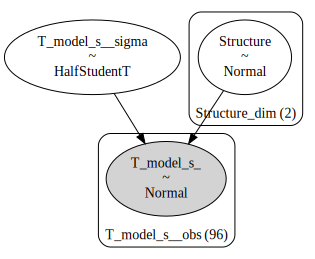

In [ ]:
# Modelo 1
model1 = bmb.Model("T_model_s_ ~ 0+Structure", df[df['Cladding']=='Metal Panels'], family='gaussian',link='identity')

# Ver el modelo
model1.build()
model1.graph()

#### Las distribuciones a priori

Una vez que tengo hecho esto, ¡todo lo que sigue para hacer la inferencia es idéntico! Ver las distribuciones a priori...

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


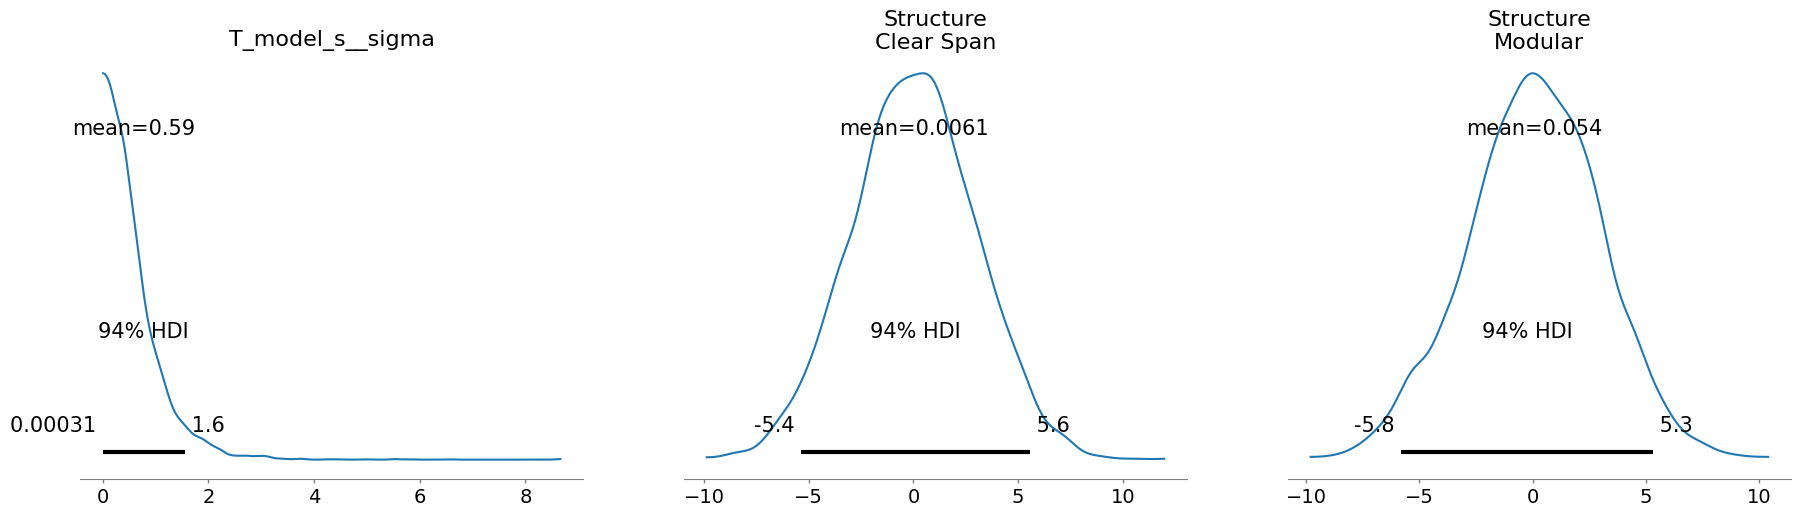

In [ ]:
# Grafico las distribuciones a priori
model1.plot_priors()
plt.show()

#### Inferencia

Realizar la inferencia...

In [ ]:
# Hago la inferencia estadística
results1 = model1.fit(chains=2,draws=1000,tune=1000,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

#### Diagnóstico de las cadenas

Evaluar las cadenas...

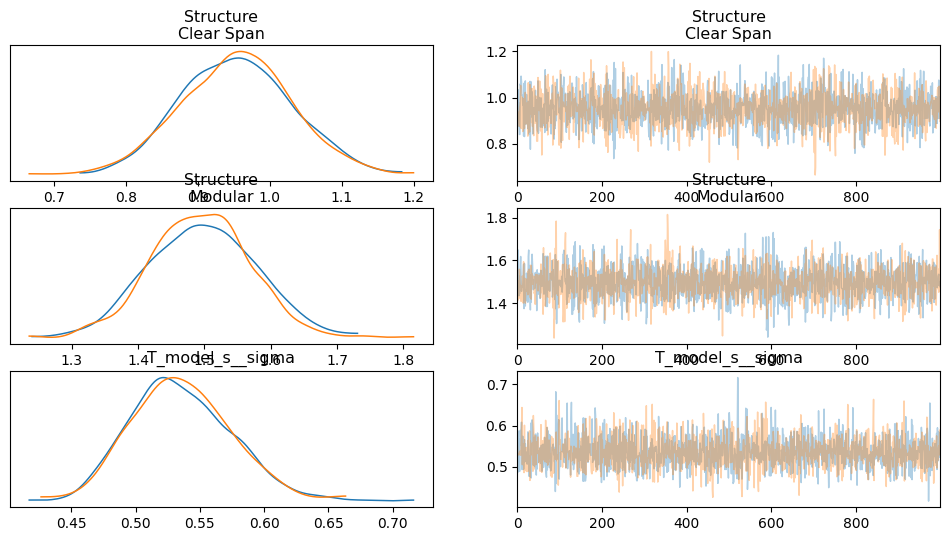

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Structure[Clear Span]  0.954  0.077   0.808    1.093      0.002    0.001   
Structure[Modular]     1.496  0.078   1.344    1.633      0.001    0.001   
T_model_s__sigma       0.536  0.039   0.466    0.607      0.001    0.001   

                       ess_bulk  ess_tail  r_hat  
Structure[Clear Span]    2569.0    1516.0    1.0  
Structure[Modular]       2845.0    1263.0    1.0  
T_model_s__sigma         2918.0    1617.0    1.0

In [ ]:
# Diagnóstico de la Cadena
az.plot_trace(results1, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results1)

#### Distribuciones posteriores

Y obtener las distribuciones posteriores de los parámetros.

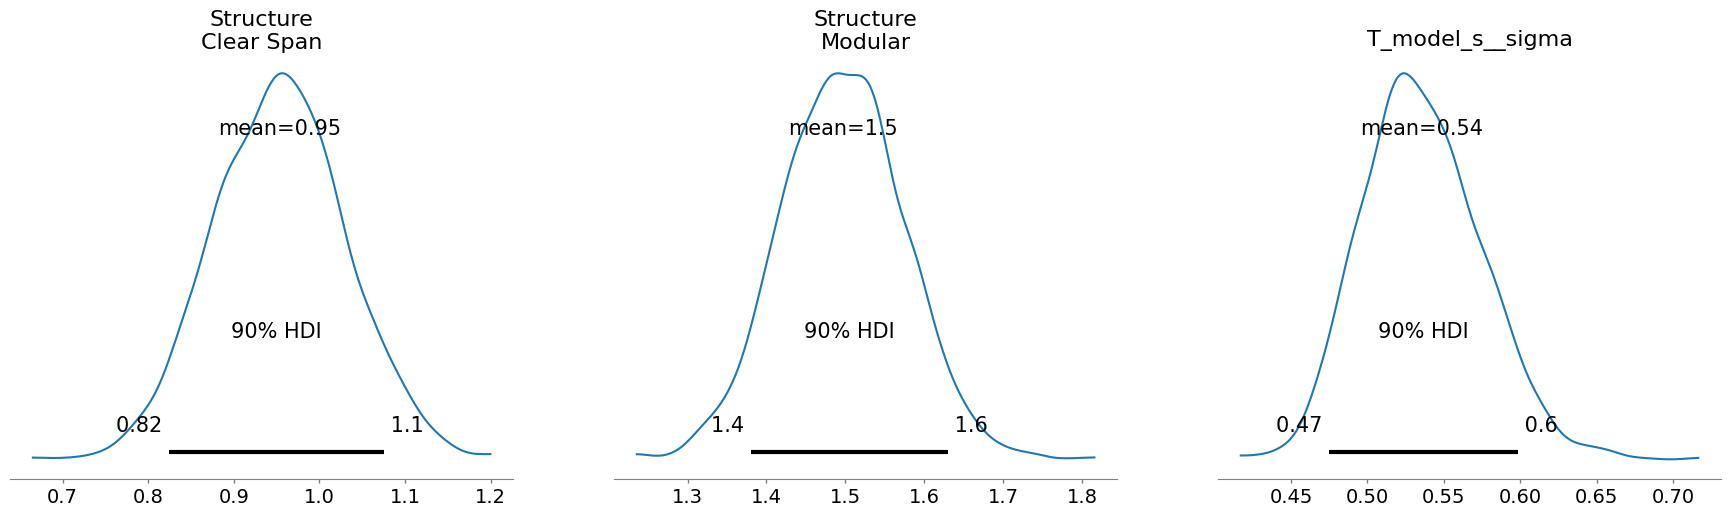

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  \
Structure[Clear Span]  0.954  0.077   0.824    1.076      0.002    0.001   
Structure[Modular]     1.496  0.078   1.380    1.631      0.001    0.001   
T_model_s__sigma       0.536  0.039   0.475    0.598      0.001    0.001   

                       ess_bulk  ess_tail  r_hat  
Structure[Clear Span]    2569.0    1516.0    1.0  
Structure[Modular]       2845.0    1263.0    1.0  
T_model_s__sigma         2918.0    1617.0    1.0

In [ ]:
az.plot_posterior(results1, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results1,hdi_prob=0.9)

#### Posterior predictiva

Y la posterior predictiva.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


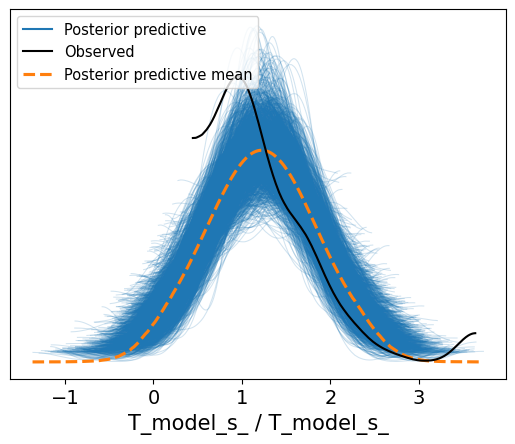

In [ ]:
# Hacer predicciones con mi modelo
model1.predict(results1,kind='pps')

# Visualizar predicciones
az.plot_ppc(results1)
plt.show()

Hasta acá todo bien, pero el gráfico de arriba no me dice nada, porque me está mezclando datos galpones modulares con datos de galpones clear span. Para hacerlo bien, habría que graficarlo por separado.

Más facil es hacerlo a mano:

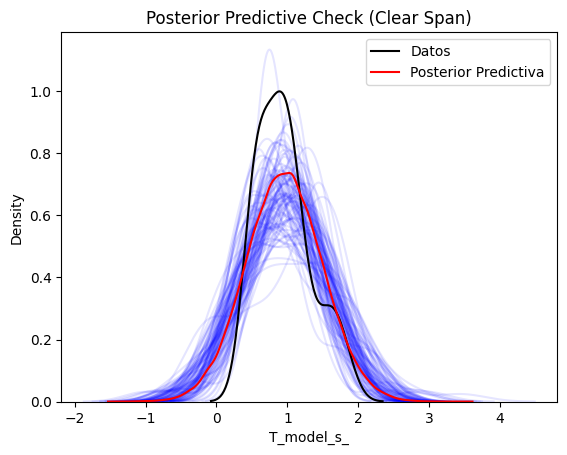

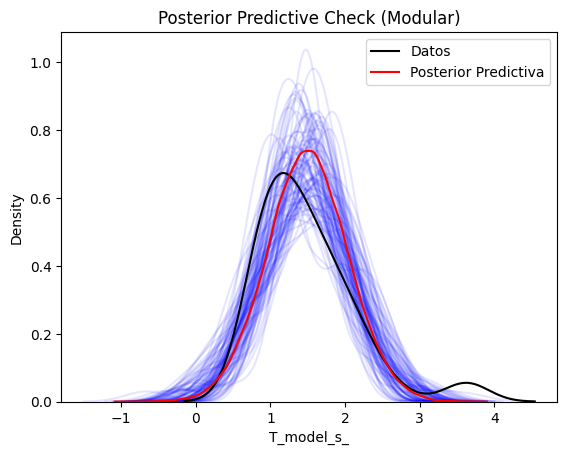

In [ ]:
# Accedo a los datos de las simulaciones
X_sim = results1.posterior_predictive['T_model_s_']

# Separo en Clear Span y Modular
X_sim_sin = X_sim[:,:,df[df['Cladding']=='Metal Panels']['Structure']=="Clear Span"]
X_sim_con = X_sim[:,:,df[df['Cladding']=='Metal Panels']['Structure']=="Modular"]

# Agrupo las simulaciones en el mismo tamaño que mi ensayo
X_simG = np.reshape(np.ravel(X_sim_sin),(-1,np.sum(df[df['Cladding']=='Metal Panels']['Structure']=="Clear Span"))).T
X_simG2 = np.reshape(np.ravel(X_sim_con),(-1,np.sum(df[df['Cladding']=='Metal Panels']['Structure']=="Modular"))).T

# Grafico algunas de las 4000 replicas
for i in range(100):
  sns.kdeplot(X_simG[:,i],label=None,color='blue',alpha=0.1)
sns.kdeplot(df[df['Cladding']=='Metal Panels']['T_model_s_'][df[df['Cladding']=='Metal Panels']['Structure']=="Clear Span"],label='Datos',color='black')
sns.kdeplot(np.ravel(X_sim_sin),label='Posterior Predictiva',color='red')
plt.legend()
plt.title('Posterior Predictive Check (Clear Span)')
plt.show()

# Grafico algunas de las 4000 replicas
for i in range(100):
  sns.kdeplot(X_simG2[:,i],label=None,color='blue',alpha=0.1)
sns.kdeplot(df[df['Cladding']=='Metal Panels']['T_model_s_'][df[df['Cladding']=='Metal Panels']['Structure']=="Modular"],label='Datos',color='black')
sns.kdeplot(np.ravel(X_sim_con),label='Posterior Predictiva',color='red')
plt.legend()
plt.title('Posterior Predictive Check (Modular)')
plt.show()

Como pueden ver, el modelo (con sus pormenores), parece andar relativamente bien. Los problemas más grandes son que predice valores negativos de período (con probabilidad muy muy baja, pero bueno), y que al usar el mismo desvío para ambas estructuras no logra predecir bien la dispersión del caso Clear Span.

#### Estudio del modelo

Una vez que llegué acá, puedo usar el modelo de forma similar a lo que venimos viendo. Por ejemplo, puedo ver si la diferencia entre valores medios de tipologías estructurales es significativa. Para ello, voy a usar una ROPE de +/-0.2s para la diferencia entre valores medios de períodos.

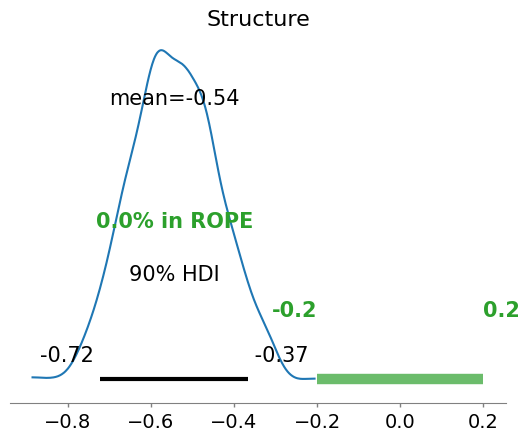

In [ ]:
Rdiff = results1.posterior['Structure'][:,:,0] - results1.posterior['Structure'][:,:,1]

# Resumen de la inferencia
az.plot_posterior(Rdiff,hdi_prob=0.9,rope=[-0.2,0.2])
plt.show()

De donde se puede ver que *con este modelo* la tipología estructural es significativa.

### Modelo 2: Regresión con predictor continuo

Si volvemos a ver los gráficos del análisis exploratorio de datos se podía ver, por ejemplo, que parece haber una relación entre el peso de los galpones y su período.

Veamos entonces, como hacer una regresión lineal con predictor continuo.

$$T_{s}|W \sim N(\mu=a+b\cdot W,\sigma)$$

**Spoiler**: ¡Es exactamente lo mismo!

Para ello escribimos simplemente `T_model_s ~ W_kip_` como fórmula. `Bambi` automáticamente multiplica a `W_kip_` por una constante que hay que calibrar. Por default el modelo incluye ordenada al origen, para eliminarla se puede escribir `0+W_kip_`. La importancia o necesidad de un `Intercept` queda a cuenta del modelador.

Una vez definido esto, es todo lo mismo.

#### Construcción del modelo

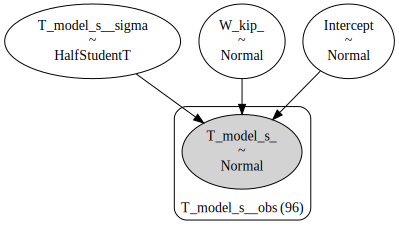

In [ ]:
# Modelo 2
model2 = bmb.Model("T_model_s_ ~ W_kip_", df[df['Cladding']=='Metal Panels'], family='gaussian',link='identity')

# Ver el modelo
model2.build()
model2.graph()

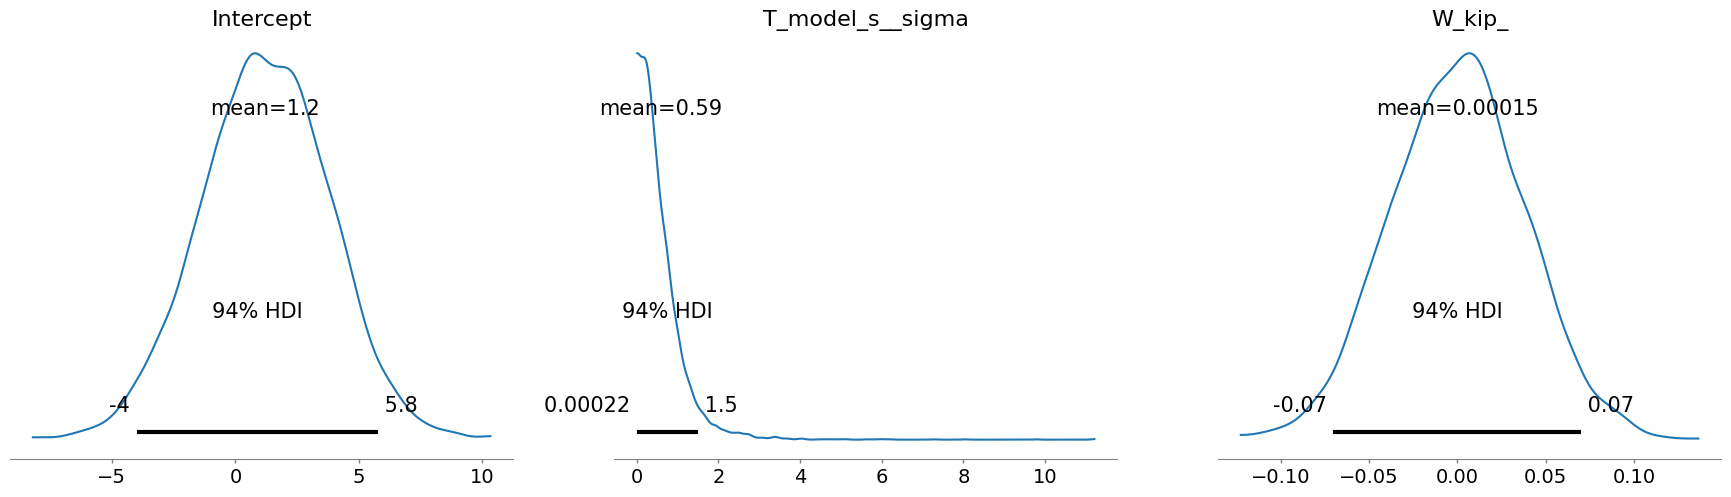

In [ ]:
# Grafico las distribuciones a priori
model2.plot_priors()
plt.show()

In [ ]:
# Hago la inferencia estadística
results2 = model2.fit(chains=2,draws=1000,tune=1000,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

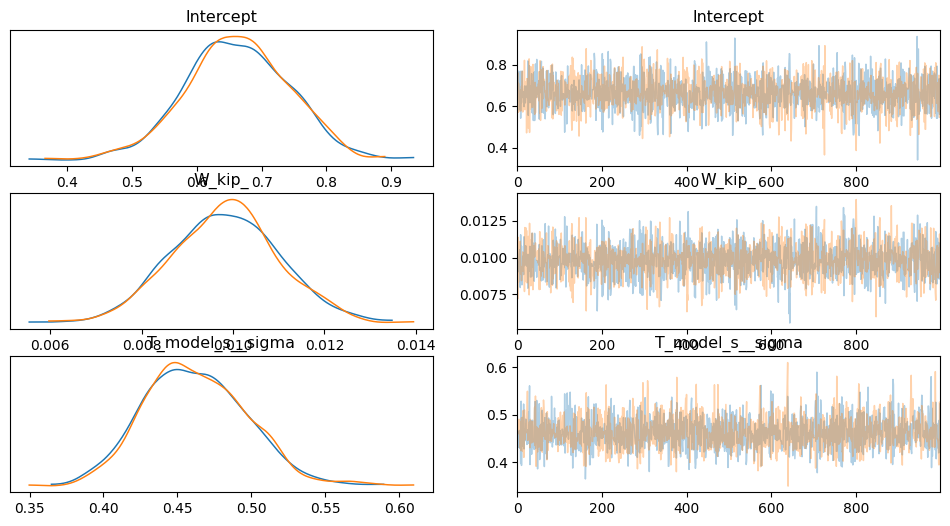

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept         0.663  0.079   0.526    0.819      0.001    0.001    3085.0   
W_kip_            0.010  0.001   0.008    0.012      0.000    0.000    2629.0   
T_model_s__sigma  0.463  0.035   0.402    0.528      0.001    0.000    2448.0   

                  ess_tail  r_hat  
Intercept           1295.0    1.0  
W_kip_              1351.0    1.0  
T_model_s__sigma    1212.0    1.0

In [ ]:
# Diagnóstico de la Cadena
az.plot_trace(results2, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results2)

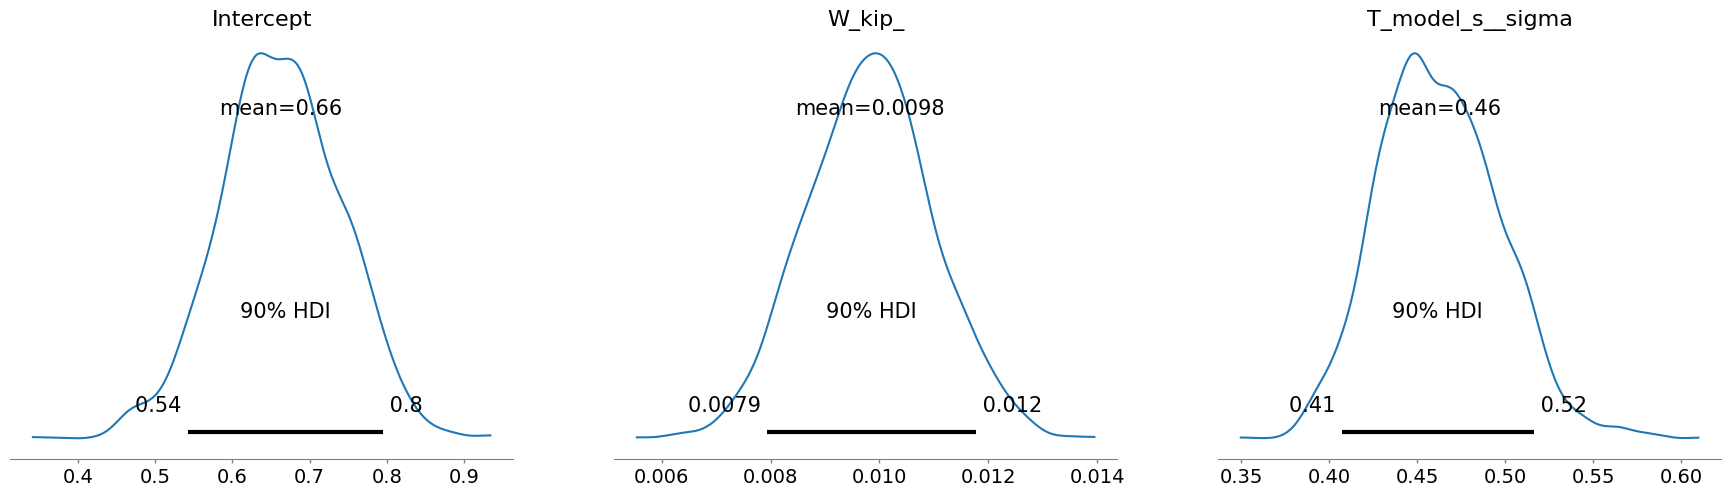

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
Intercept         0.663  0.079   0.542    0.795      0.001    0.001    3085.0   
W_kip_            0.010  0.001   0.008    0.012      0.000    0.000    2629.0   
T_model_s__sigma  0.463  0.035   0.407    0.516      0.001    0.000    2448.0   

                  ess_tail  r_hat  
Intercept           1295.0    1.0  
W_kip_              1351.0    1.0  
T_model_s__sigma    1212.0    1.0

In [ ]:
az.plot_posterior(results2, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results2,hdi_prob=0.9)

In [ ]:
# Hacer predicciones con mi modelo
model2.predict(results2,kind='pps')

#### Visualización y evaluación de residuos

Bien, tenemos nuestro modelo "ajustado", y queremos ahora visualizar los datos. Ahora empieza a perder sentido graficar las curvas de densidad de probabilidad porque el valor medio es una función del peso y, como el peso es continuo, para cada valor tengo con suerte un dato para comparar.

Lo que se construye entonces en un gráfico que muestra la predicción y los intervalos de confianza, ya sea para el valor medio o para la predicción, de forma tal de poder ver fácilmente si los datos caen dentro de lo esperado.

Esto se puede hacer con la función `bmb.interpret.plot_predictions` de `Bambi`.En esta se incluye:
- El modelo
- Los resultados de la inferencia y predicciones
- Una lista con las variables con la cual condicionar el modelo
- pps: si queremos dibujar la incertidumbre del valor medio o de la predicción.
- el valor a tener en cuenta para el HDI

Después veremos que hay más opciones, pero con esto se empieza. El gráfico van a ver que muestra para cada valor de `W_kip_` la posterior predictiva para el valor medio y su incertidumbre (sea la del valor medio o la nueva observación).

Manualmente pueden agregarle a ese gráfico los datos observados para evaluar.

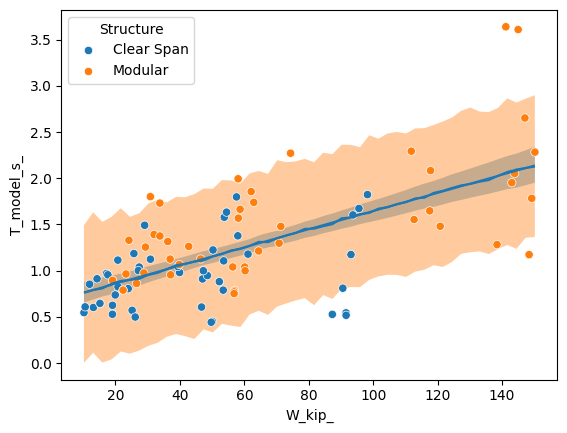

In [ ]:
fig, ax = bmb.interpret.plot_predictions(model2,results2,'W_kip_',pps=False,prob=0.9)
bmb.interpret.plot_predictions(model2,results2,'W_kip_',pps=True,prob=0.9,ax=ax)
sns.scatterplot(x='W_kip_', y='T_model_s_', hue='Structure',data=df[df['Cladding']=='Metal Panels'])
plt.show()

Además, ustedes pueden manualmente setear exactamente a qué valores (de, por ejemplo, peso) condicionar el gráfico. Esto es muy útil para ver cómo extrapola la función, o para analizar un caso particular.



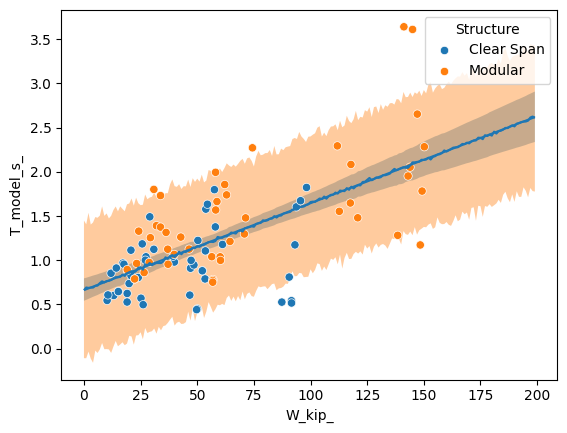

In [ ]:
fig, ax = bmb.interpret.plot_predictions(model2,results2,conditional={'W_kip_':np.array(range(200))},pps=False,prob=0.9)
bmb.interpret.plot_predictions(model2,results2,conditional={'W_kip_':np.array(range(200))},pps=True,prob=0.9,ax=ax)
sns.scatterplot(x='W_kip_', y='T_model_s_', hue='Structure',data=df[df['Cladding']=='Metal Panels'])
plt.show()

Otra cosa muy útil para hacer un diagnóstico del modelo es mirar los residuos. En el modelo que construimos dijimos que el desvío estandar era único y constante, por lo que los residuos deben estar centrados en 0 y con una dispersión constante para todo valor de `W_kip_` (o de `T_model_s`, como prefieran varlo).

Chequiemos primero la dsitrbución de los residuos (les dejamos el código escrito para que tengan)

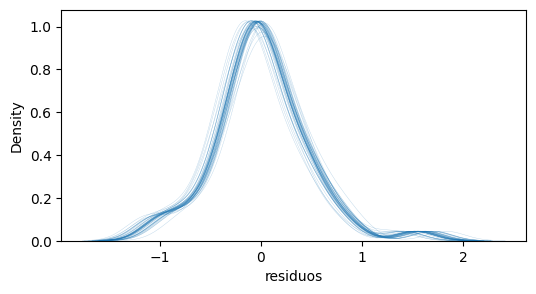

In [ ]:
y_obs = df[df['Cladding']=='Metal Panels']['T_model_s_']
fig, ax = plt.subplots( figsize=(6,3) )
for i in range(100,150):
  mu_pred = results2.posterior["Intercept"].sel(chain=0,draw=i).values+\
  results2.posterior["W_kip_"].sel(chain=0,draw=i).values * df[df['Cladding']=='Metal Panels'].W_kip_
  residuals = y_obs - mu_pred
  sns.kdeplot( residuals, ax=ax, linewidth=.3, alpha=.3, color='C0' )

ax.set_xlabel('residuos')
plt.show()

Bien, los residuos parecen aproximadamente normales y centrados en 0 (podría hacer qq-plots, bpv, lo que querramos para testear). Pero... ¿depende la dispersión de las variables o su valor medio de las variables?

Veamoslo gráficamente (les dejamos el código)

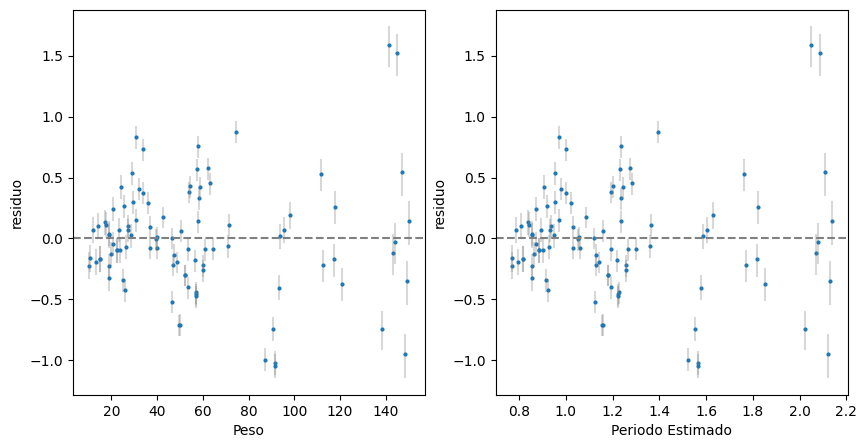

In [ ]:
y_obs = df[df['Cladding']=='Metal Panels']['T_model_s_'].to_numpy()

fig, (axs) = plt.subplots(1, 2,figsize=(10,5))

xx = df[df['Cladding']=='Metal Panels'].W_kip_.to_numpy()

for i in range(len(xx)):
  mu_pred = mu_pred = results2.posterior["Intercept"].sel(chain=0,draw=slice(1,150)).values+\
  results2.posterior["W_kip_"].sel(chain=0,draw=slice(1,150)).values * xx[i]
  residuals = y_obs[i] - mu_pred
  quantiles = np.quantile(residuals, 0.05), np.quantile(residuals, 0.95)
  axs[0].plot( [xx[i],xx[i]], quantiles, color='gray', alpha=.3 )
  axs[0].plot( xx[i], residuals.mean(), 'o', color='C0', markersize=2)

  axs[1].plot( [mu_pred.mean(),mu_pred.mean()], quantiles, color='gray', alpha=.3 )
  axs[1].plot( mu_pred.mean(), residuals.mean(), 'o', color='C0', markersize=2)

axs[0].axhline( y=0, linestyle='--', color='gray', linewidth=1.5)
axs[0].set_ylabel('residuo')
axs[0].set_xlabel('Peso')

axs[1].axhline( y=0, linestyle='--', color='gray', linewidth=1.5)
axs[1].set_ylabel('residuo')
axs[1].set_xlabel('Periodo Estimado')
plt.show()

Notarán que los residuaos están efectivamente centrados alrededor del 0 para todos los pesos (la formula lineal podría estar bien), pero que la dispersión va en aumento! Esto último me preocupa, porque quiere decir que no es constante el valor de $\sigma$ en los datos. El modelo Normal puede que no sea el mejor.

Esto lo vamos a volver a mirar con los modelos 6 y 7.

### Modelo 3: Combinando predictores

A ver, vimos como incluir predictores categóricos y continuos... ¿por qué no mezclarlos?

En particular, veamos primero un modelo donde la ordenada al origen depende de una variable categórica, y a su vez existe un pendiente en función de una variable continua. Digamos, la suma del modelo 1 con el modelo 2:

$$T|Structure,W \sim N(\mu = a_{Structure}+b\cdot W,\sigma)$$

La carga en `Bambi` es directa, ya que sabe cómo distinguir entre variables categóricas y continuas en su formulación.

Y después, todo se repite...

#### Construcción del modelo

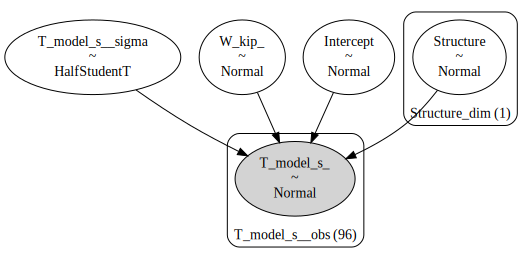

In [ ]:
# Modelo 3
model3 = bmb.Model("T_model_s_ ~ Structure + W_kip_", df[df['Cladding']=='Metal Panels'], family='gaussian',link='identity')

# Ver el modelo
model3.build()
model3.graph()

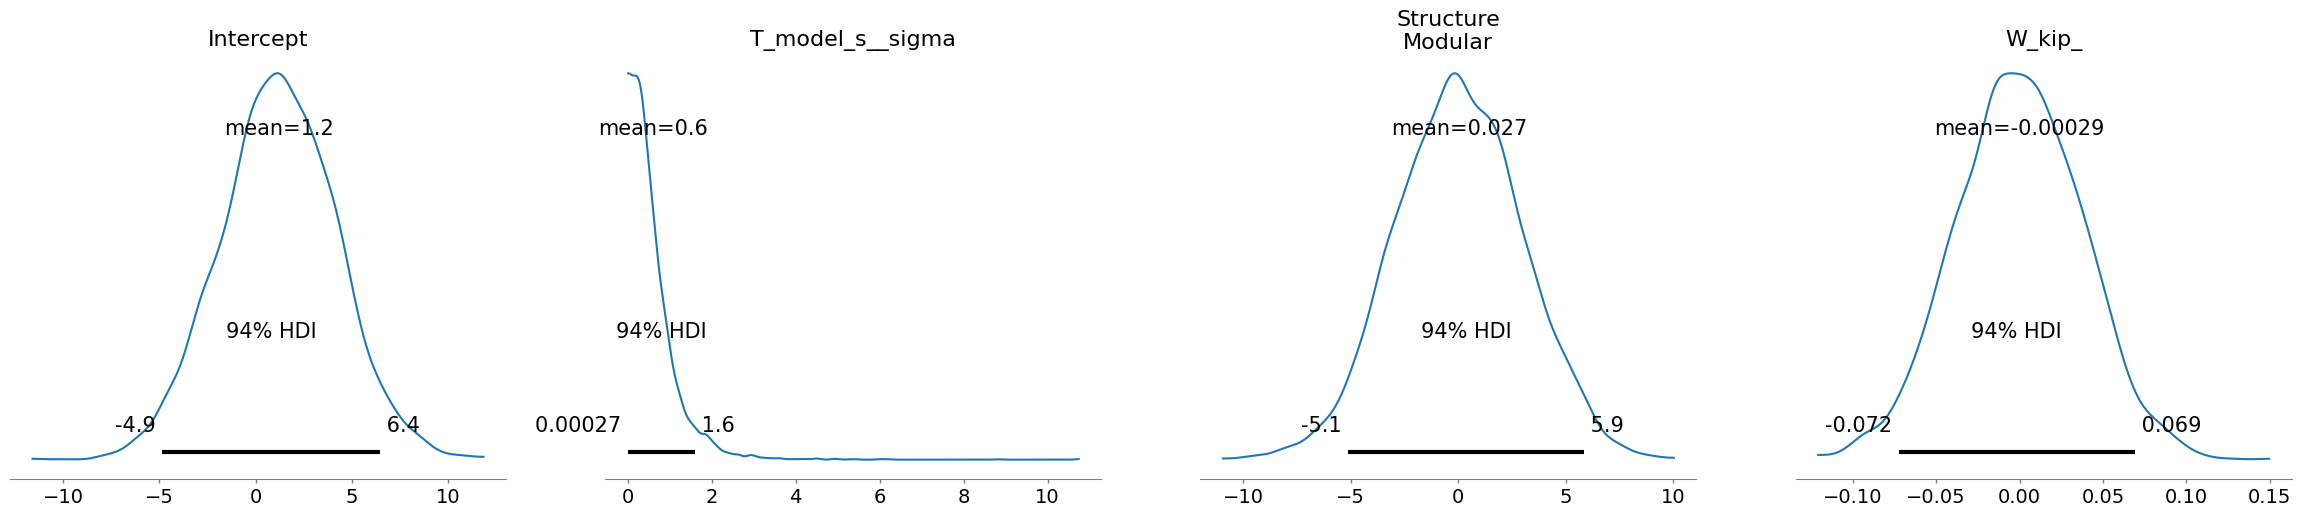

In [ ]:
# Grafico las distribuciones a priori
model3.plot_priors()
plt.show()

In [ ]:
# Hago la inferencia estadística
results3 = model3.fit(chains=2,draws=1000,tune=1000,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

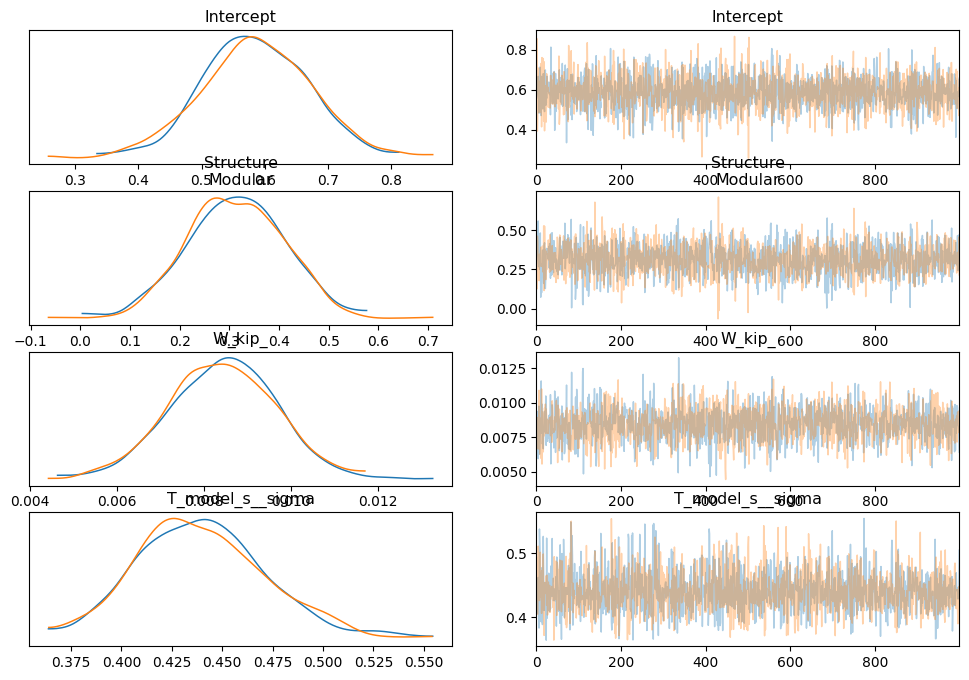

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept           0.586  0.085   0.429    0.744      0.002    0.001   
Structure[Modular]  0.313  0.098   0.132    0.487      0.002    0.001   
W_kip_              0.008  0.001   0.006    0.011      0.000    0.000   
T_model_s__sigma    0.440  0.033   0.378    0.501      0.001    0.000   

                    ess_bulk  ess_tail  r_hat  
Intercept             3134.0    1618.0    1.0  
Structure[Modular]    2425.0    1688.0    1.0  
W_kip_                2032.0    1755.0    1.0  
T_model_s__sigma      2422.0    1388.0    1.0

In [ ]:
# Diagnóstico de la Cadena
az.plot_trace(results3, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results3)

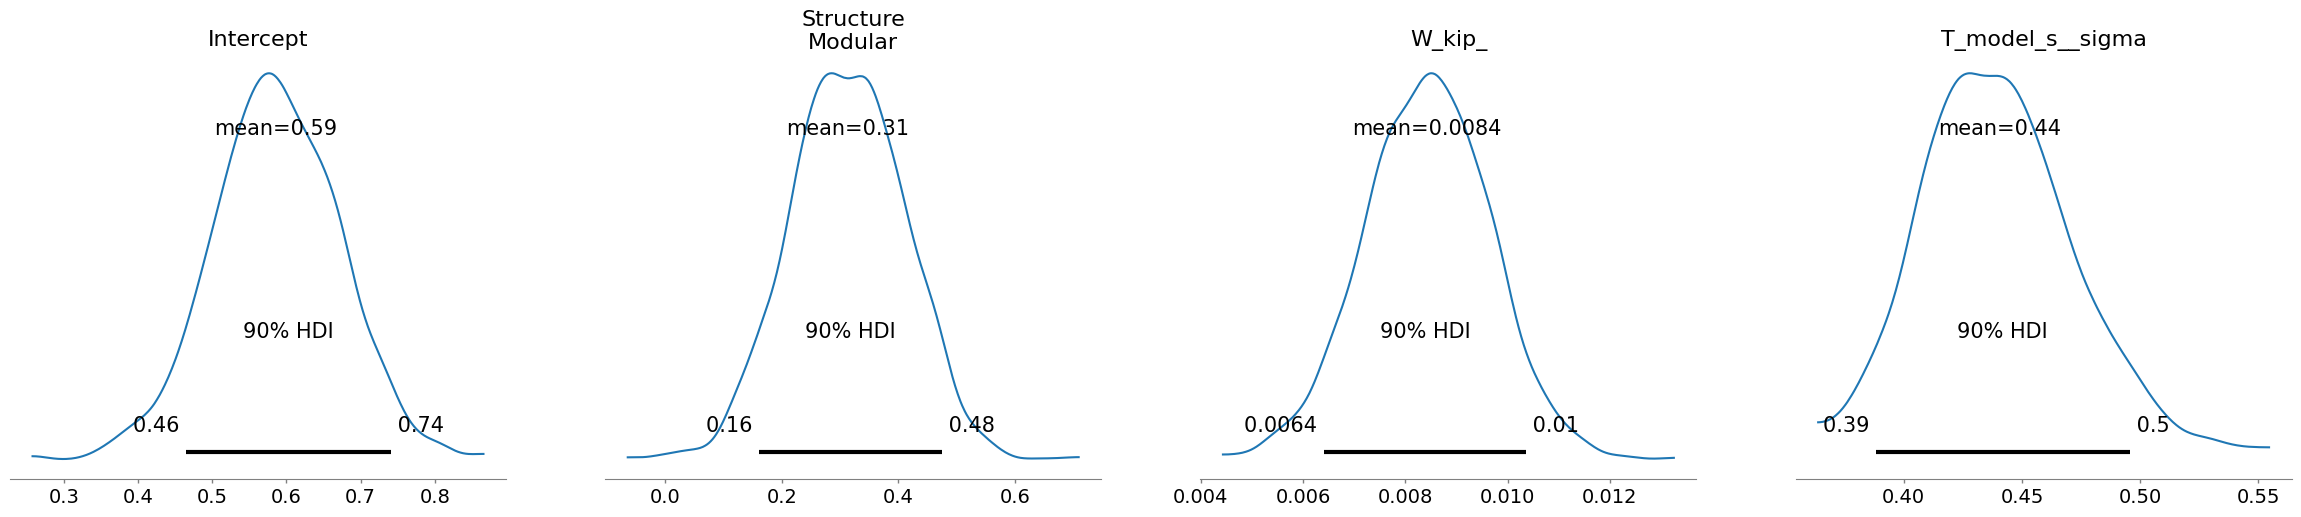

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  \
Intercept           0.586  0.085   0.465    0.741      0.002    0.001   
Structure[Modular]  0.313  0.098   0.161    0.475      0.002    0.001   
W_kip_              0.008  0.001   0.006    0.010      0.000    0.000   
T_model_s__sigma    0.440  0.033   0.388    0.496      0.001    0.000   

                    ess_bulk  ess_tail  r_hat  
Intercept             3134.0    1618.0    1.0  
Structure[Modular]    2425.0    1688.0    1.0  
W_kip_                2032.0    1755.0    1.0  
T_model_s__sigma      2422.0    1388.0    1.0

In [ ]:
az.plot_posterior(results3, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results3,hdi_prob=0.9)

In [ ]:
# Hacer predicciones con mi modelo
model3.predict(results3,kind='pps')

results3

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

#### Estudio del modelo

Con el modelo ajustado, podemos volver a ver (como hicimos en el Modelo 1) si el efecto de la tipología estructural es significativa! Por como hicimos la inferencia, simplemente hay que mirar a `Structure[Modular]` que fue calibrado como la diferencia respecto a `Clear Span`.

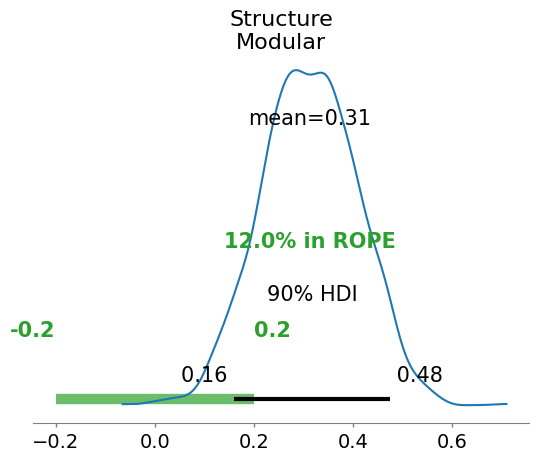

In [ ]:
# Resumen de la inferencia
az.plot_posterior(results3,var_names='Structure',hdi_prob=0.9,rope=[-0.2,0.2])
plt.show()

Noten que para *este modelo* la diferencia no es tan clara, comparado a cuando usamos el modelo 1. Las conclusiones dependen del modelo!

#### Visualización

Veamos nuevamente como ver los resultados de mi modelo con `Bambi`. Esto se puede hacer con la función `bmb.interpret.plot_predictions`. Para ello, una opción es setar 2 condicionales. Para ello utilizamos la variable `subplot_kwargs` donde se incluye como diccionario.

- `main`: la condición que vamos a graficar (en nuestro caso, en función de la altura)
- `panel`: las condiciones para las cuales vamos a generar distintos gráficos (en nuestro caso, la categoría sexo)

Los invitamos a ver la documentación de Bambi para más formas de presentar los datos!

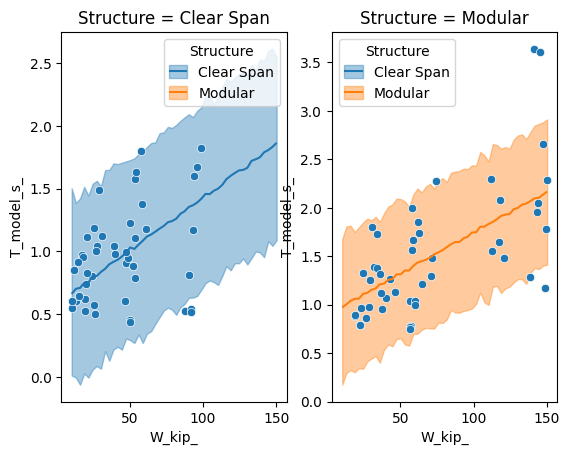

In [ ]:
fig, ax = bmb.interpret.plot_predictions(model3,results3,['W_kip_','Structure'],subplot_kwargs={'main':'W_kip_','panel':'Structure'},pps=True,prob=0.9)
sns.scatterplot(x='W_kip_', y='T_model_s_',data=df[(df['Cladding']=='Metal Panels')&(df['Structure']=='Clear Span')],ax=ax[0])
sns.scatterplot(x='W_kip_', y='T_model_s_',data=df[(df['Cladding']=='Metal Panels')&(df['Structure']=='Modular')],ax=ax[1])
plt.show()

¿Se acuerdan que ustedes podían setear manualmente las condiciones? Esto es muy útil especialmente para el caso de variables categóricas. Así puedo elegir yo qué quiero mirar.



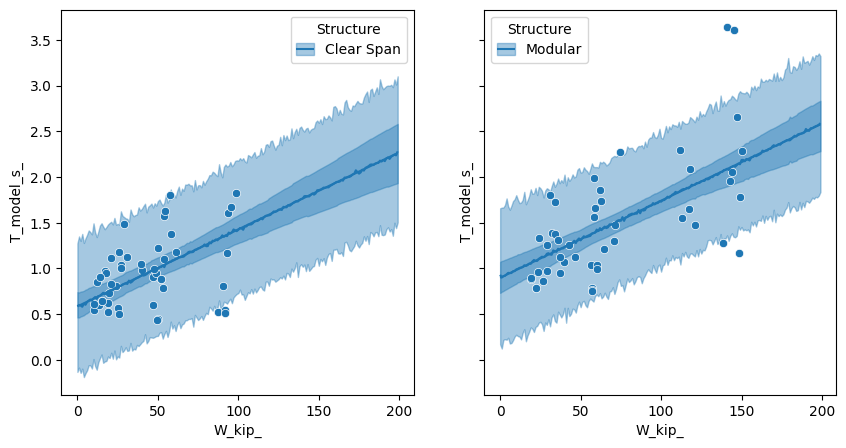

In [ ]:
fig, (axs) = plt.subplots(1, 2,figsize=(10,5),sharey=True)

bmb.interpret.plot_predictions(model3,results3,conditional={'W_kip_':np.array(range(200)),'Structure':'Clear Span'},ax=axs[0],pps=False,prob=0.9)
bmb.interpret.plot_predictions(model3,results3,conditional={'W_kip_':np.array(range(200)),'Structure':'Clear Span'},ax=axs[0],pps=True,prob=0.9)
sns.scatterplot(x='W_kip_', y='T_model_s_',data=df[(df['Cladding']=='Metal Panels')&(df['Structure']=='Clear Span')],ax=axs[0])

bmb.interpret.plot_predictions(model3,results3,conditional={'W_kip_':np.array(range(200)),'Structure':'Modular'},ax=axs[1],pps=False,prob=0.9)
bmb.interpret.plot_predictions(model3,results3,conditional={'W_kip_':np.array(range(200)),'Structure':'Modular'},ax=axs[1],pps=True,prob=0.9)
sns.scatterplot(x='W_kip_', y='T_model_s_',data=df[(df['Cladding']=='Metal Panels')&(df['Structure']=='Modular')],ax=axs[1])
plt.show()

### Modelo 4: Interacción entre predictores

Al modelo anterior le podemos agregar una pequeña vuelta más. ¿Qué pasa si la pendiente depende también de la variable categórica/tipología estructura? Es decir:

$$T|Structure,W \sim N(\mu = a_{structure} + b_{structure}\cdot W,\sigma)$$

Para definir distintas pendientes por categoría se hace `predictorContinuo:predictorCategórico`. Una vez que tengo eso, todo es igual que antes.

#### Construcción del modelo

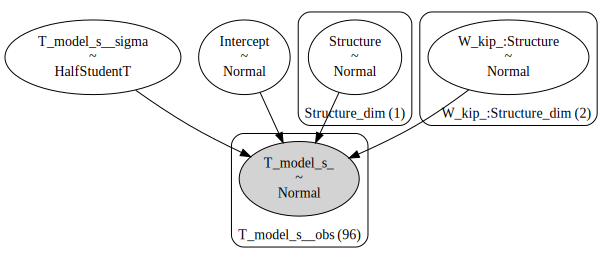

In [ ]:
# Modelo 4
model4 = bmb.Model("T_model_s_ ~ Structure + W_kip_:Structure", df[df['Cladding']=='Metal Panels'], family='gaussian',link='identity')

# Ver el modelo
model4.build()
model4.graph()

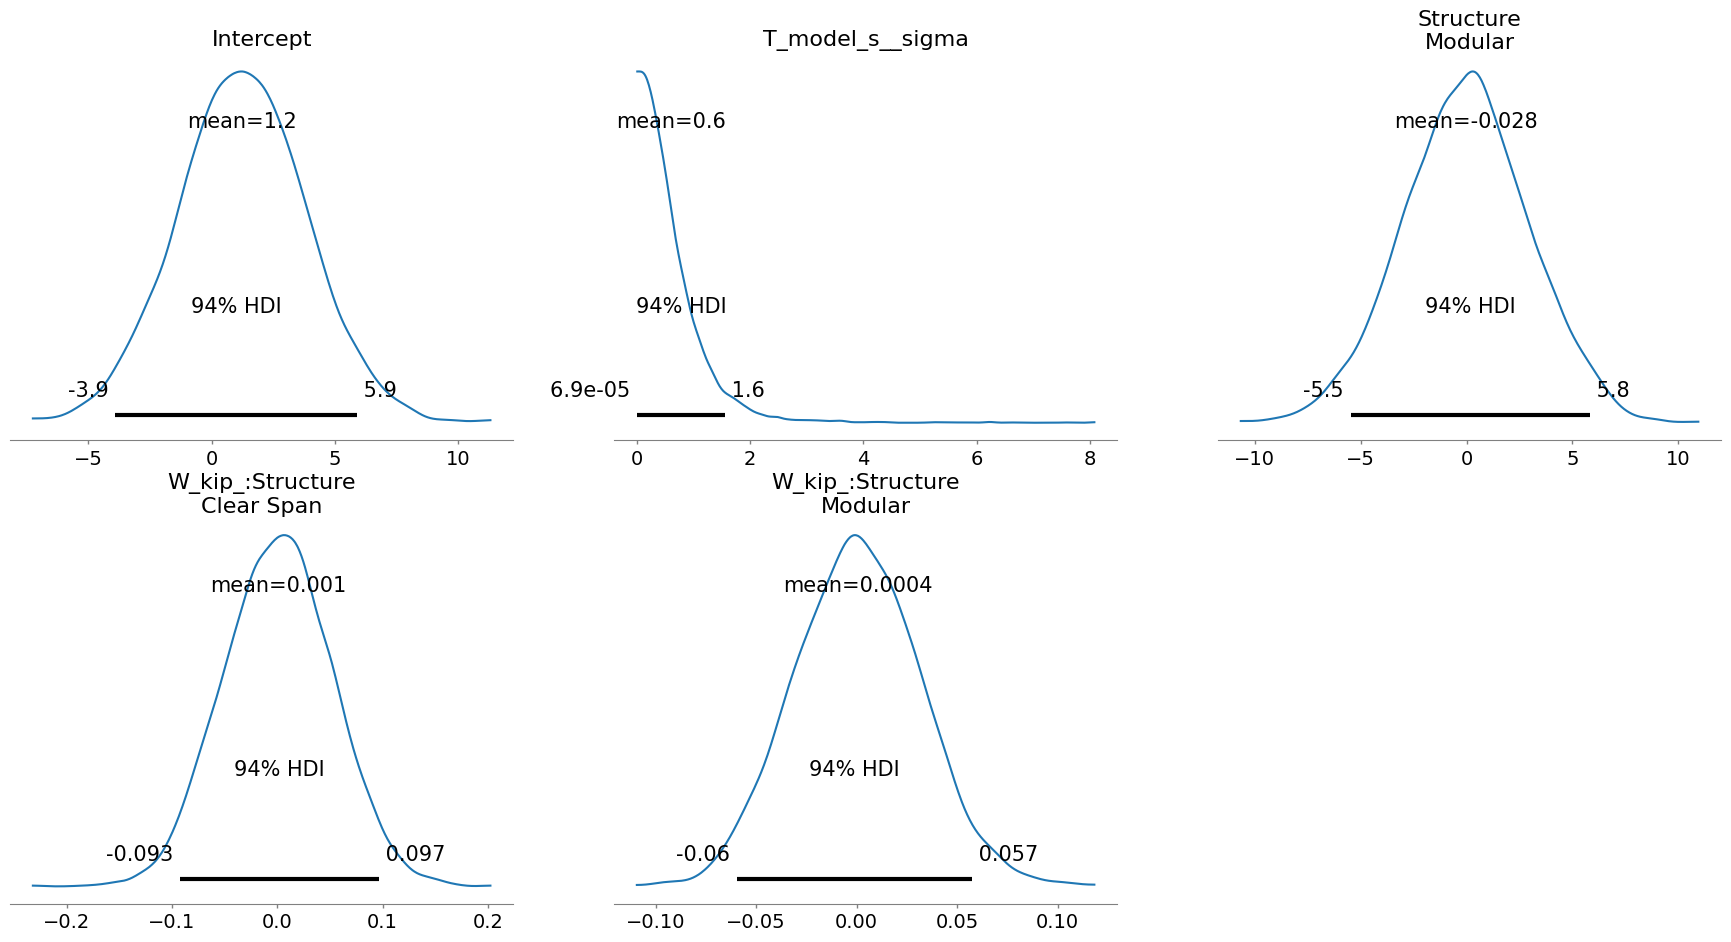

In [ ]:
# Grafico las distribuciones a priori
model4.plot_priors()
plt.show()

In [ ]:
# Hago la inferencia estadística
results4 = model4.fit(chains=2,draws=1000,tune=1000,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

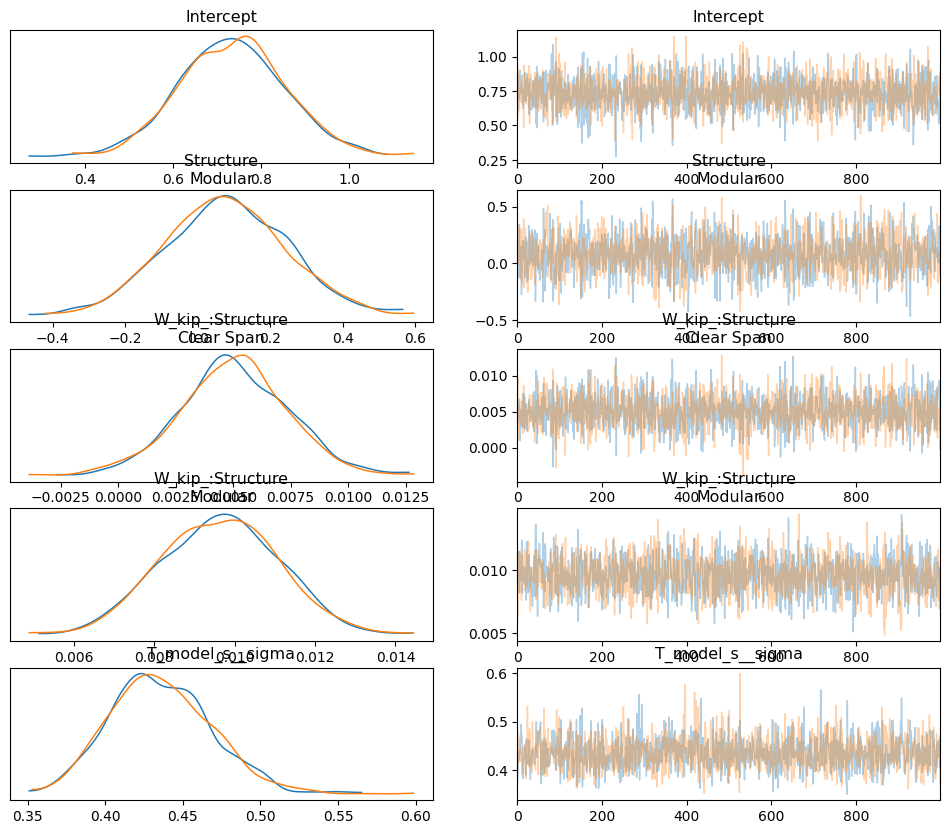

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                     0.734  0.121   0.509    0.965      0.003   
Structure[Modular]            0.078  0.168  -0.229    0.395      0.004   
W_kip_:Structure[Clear Span]  0.005  0.002   0.000    0.009      0.000   
W_kip_:Structure[Modular]     0.010  0.001   0.007    0.012      0.000   
T_model_s__sigma              0.436  0.033   0.379    0.500      0.001   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                       0.002    2220.0    1508.0    1.0  
Structure[Modular]              0.003    1722.0    1604.0    1.0  
W_kip_:Structure[Clear Span]    0.000    2016.0    1487.0    1.0  
W_kip_:Structure[Modular]       0.000    2031.0    1445.0    1.0  
T_model_s__sigma                0.001    1758.0    1592.0    1.0

In [ ]:
# Diagnóstico de la Cadena
az.plot_trace(results4, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results4)

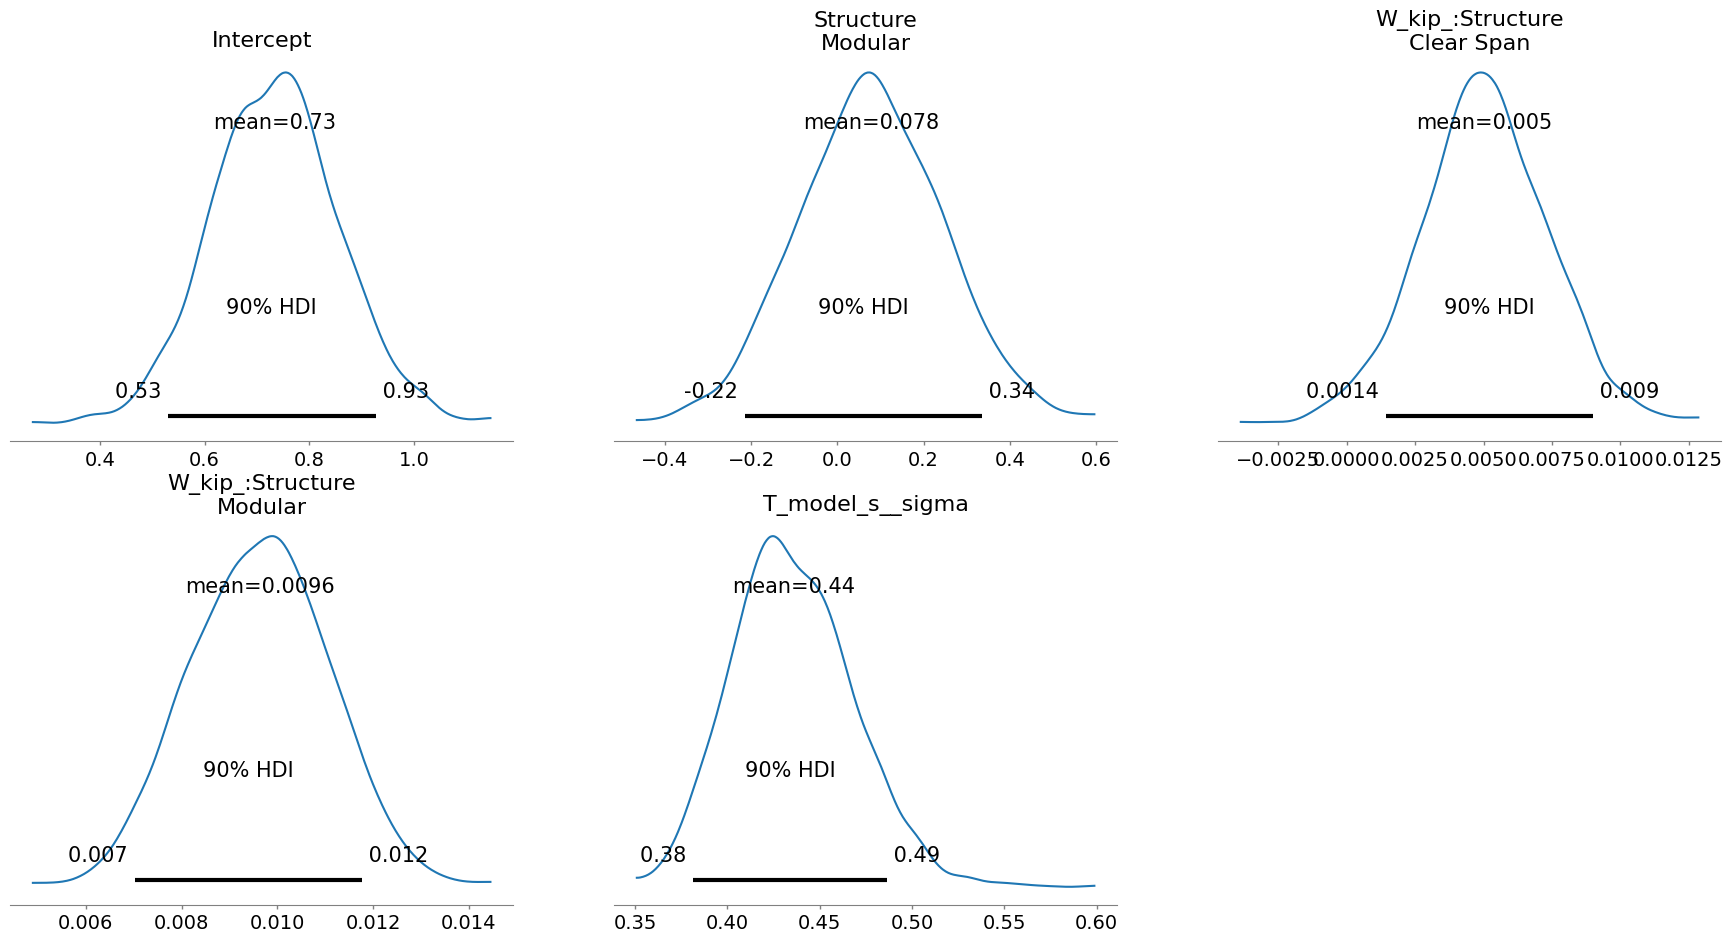

mean     sd  hdi_5%  hdi_95%  mcse_mean  \
Intercept                     0.734  0.121   0.530    0.926      0.003   
Structure[Modular]            0.078  0.168  -0.215    0.336      0.004   
W_kip_:Structure[Clear Span]  0.005  0.002   0.001    0.009      0.000   
W_kip_:Structure[Modular]     0.010  0.001   0.007    0.012      0.000   
T_model_s__sigma              0.436  0.033   0.381    0.486      0.001   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                       0.002    2220.0    1508.0    1.0  
Structure[Modular]              0.003    1722.0    1604.0    1.0  
W_kip_:Structure[Clear Span]    0.000    2016.0    1487.0    1.0  
W_kip_:Structure[Modular]       0.000    2031.0    1445.0    1.0  
T_model_s__sigma                0.001    1758.0    1592.0    1.0

In [ ]:
az.plot_posterior(results4, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results4,hdi_prob=0.9)

In [ ]:
# Hacer predicciones con mi modelo
model4.predict(results4,kind='pps')

results4

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

#### Estudio del modelo

Con el modelo ajustado, podemos volver a ver (como hicimos en el Modelo 1 o 2) si el efecto de la tipología estructural es significativa! Por como hicimos la inferencia, simplemente hay que mirar a `Structure[Modular]` que fue calibrado como la diferencia respecto a `Clear Span`.

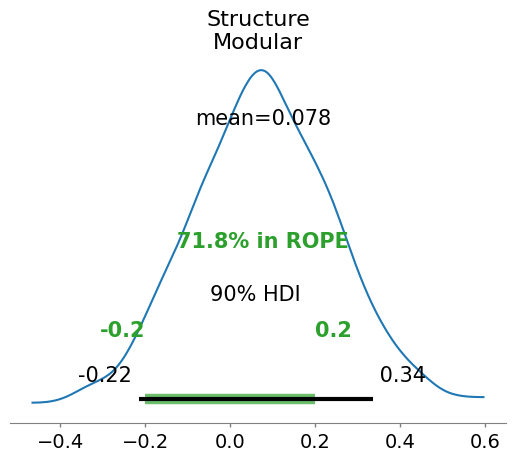

In [ ]:
# Resumen de la inferencia
az.plot_posterior(results4,var_names='Structure',hdi_prob=0.9,rope=[-0.2,0.2])
plt.show()

Noten que para *este modelo* la diferencia en la ordenada al origen es nula! Pero, qué me dicen de la pendiente?

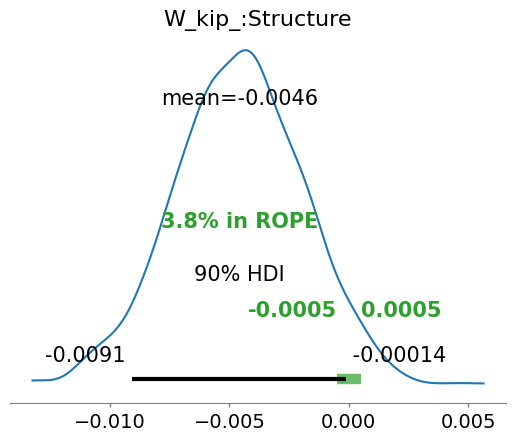

In [ ]:
Rdiff = results4.posterior['W_kip_:Structure'][:,:,0] - results4.posterior['W_kip_:Structure'][:,:,1]

# Resumen de la inferencia
az.plot_posterior(Rdiff,hdi_prob=0.9,rope=[-0.0005,0.0005])
plt.show()

Claro, el modelo lo que me está diciendo es que la influencia de la tipología estructural esta en la pendiente, no en la ordenada al origen!

#### Visualización

Veamos nuevamente como ver los resultados de mi modelo con `Bambi`. Esto se puede hacer con la función `bmb.interpret.plot_predictions`. Para ello, una opción es setar 2 condicionales. Para ello utilizamos la variable `subplot_kwargs` donde se incluye como diccionario.

- `main`: la condición que vamos a graficar (en nuestro caso, en función de la altura)
- `panel`: las condiciones para las cuales vamos a generar distintos gráficos (en nuestro caso, la categoría sexo)

Los invitamos a ver la documentación de Bambi para más formas de presentar los datos!

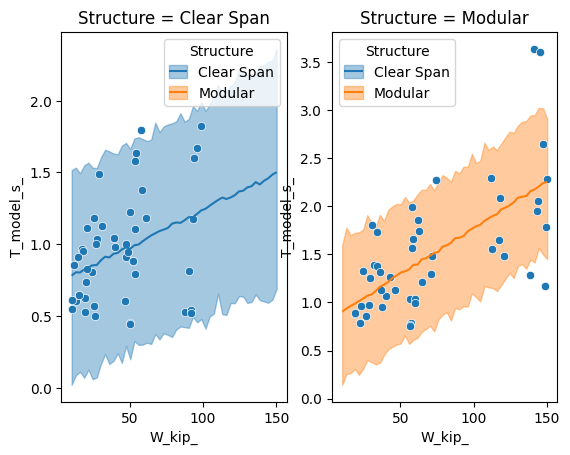

In [ ]:
fig, ax = bmb.interpret.plot_predictions(model4,results4,['W_kip_','Structure'],subplot_kwargs={'main':'W_kip_','panel':'Structure'},pps=True,prob=0.9)
sns.scatterplot(x='W_kip_', y='T_model_s_',data=df[(df['Cladding']=='Metal Panels')&(df['Structure']=='Clear Span')],ax=ax[0])
sns.scatterplot(x='W_kip_', y='T_model_s_',data=df[(df['Cladding']=='Metal Panels')&(df['Structure']=='Modular')],ax=ax[1])
plt.show()

¿Se acuerdan que ustedes podían setear manualmente las condiciones? Esto es muy útil especialmente para el caso de variables categóricas. Así puedo elegir yo qué quiero mirar (y se va a ver mucho mejor).



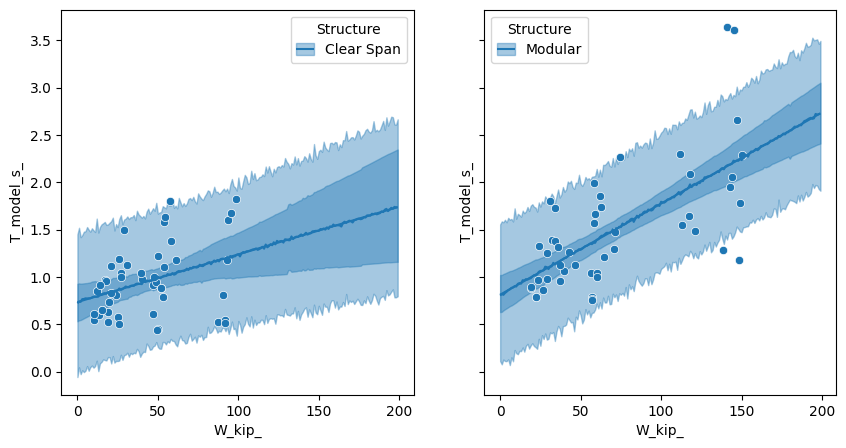

In [ ]:
fig, (axs) = plt.subplots(1, 2,figsize=(10,5),sharey=True)

bmb.interpret.plot_predictions(model4,results4,conditional={'W_kip_':np.array(range(200)),'Structure':'Clear Span'},ax=axs[0],pps=False,prob=0.9)
bmb.interpret.plot_predictions(model4,results4,conditional={'W_kip_':np.array(range(200)),'Structure':'Clear Span'},ax=axs[0],pps=True,prob=0.9)
sns.scatterplot(x='W_kip_', y='T_model_s_',data=df[(df['Cladding']=='Metal Panels')&(df['Structure']=='Clear Span')],ax=axs[0])

bmb.interpret.plot_predictions(model4,results4,conditional={'W_kip_':np.array(range(200)),'Structure':'Modular'},ax=axs[1],pps=False,prob=0.9)
bmb.interpret.plot_predictions(model4,results4,conditional={'W_kip_':np.array(range(200)),'Structure':'Modular'},ax=axs[1],pps=True,prob=0.9)
sns.scatterplot(x='W_kip_', y='T_model_s_',data=df[(df['Cladding']=='Metal Panels')&(df['Structure']=='Modular')],ax=axs[1])
plt.show()

### Modelo 5: Modelos distribucionales

Uno podría ver los resultados de los modelos anteriores y pensar ¿por qué no podría modificar el valor de $sigma$ también?

Efectivamente, eso es posible en `Bambi`, y se le puede dar cualquier función de predictore, igual que al valor medio.

Con la función `bmb.Formula` y eligiendo nosostros una función para `sigma`. Vamos a construirla de tal forma que me defina desvíos por separado. En este caso haremos que:

$$T|Structure,W \sim N(\mu = a_{structure} + b_{structure}\cdot W,\sigma_{structure})$$

Y después, todo es lo mismo.

#### Construcción del modelo

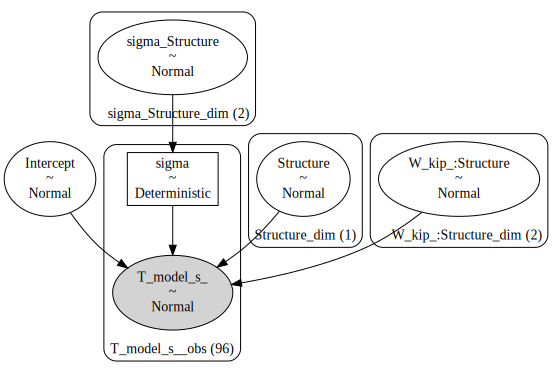

In [ ]:
# Modelo 5
formula = bmb.Formula("T_model_s_ ~ Structure + W_kip_:Structure","sigma ~ 0+Structure")
model5 = bmb.Model(formula, df[df['Cladding']=='Metal Panels'], family='gaussian',link={"mu": "identity", "sigma": "log"})

# Ver el modelo
model5.build()
model5.graph()

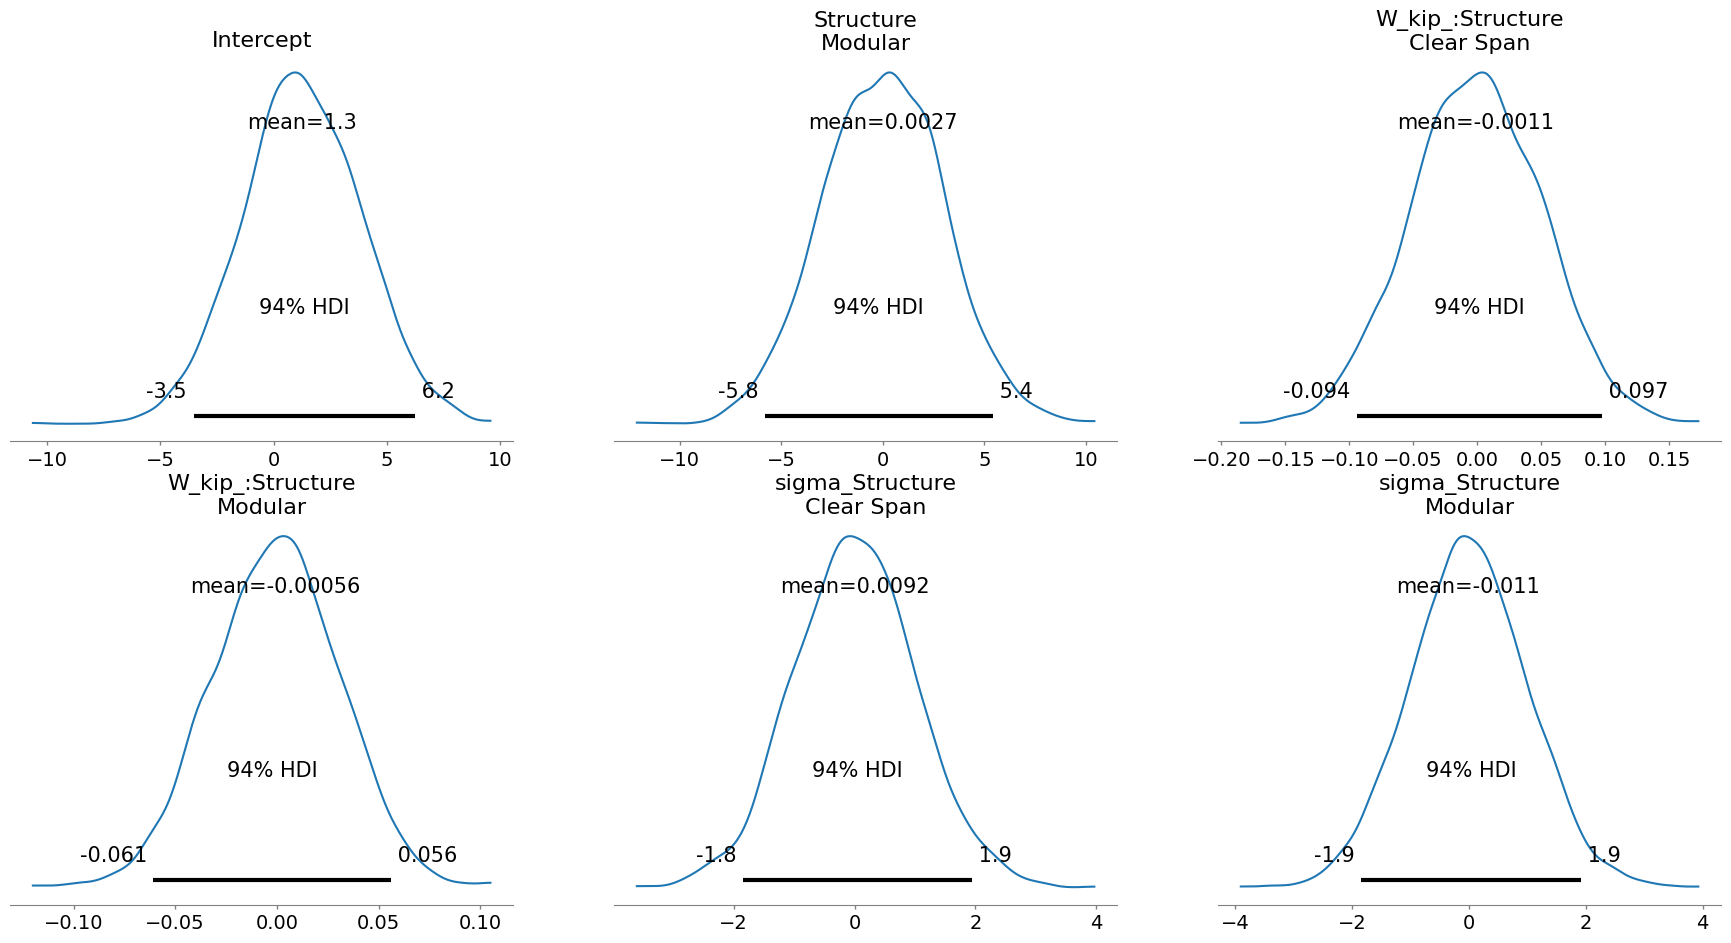

In [ ]:
# Grafico las distribuciones a priori
model5.plot_priors(var_names=['Intercept','Structure','W_kip_:Structure','sigma_Structure'])
plt.show()

In [ ]:
# Hago la inferencia estadística
results5 = model5.fit(chains=2,draws=1000,tune=1000,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

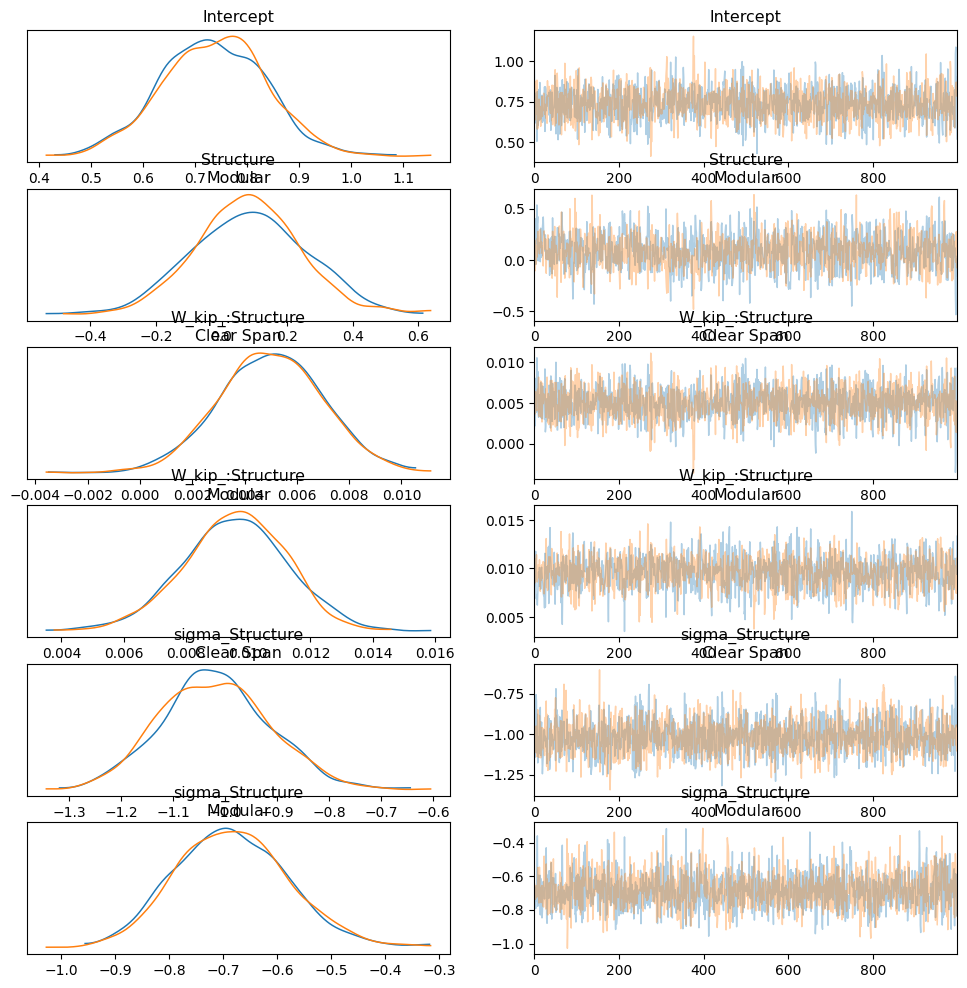

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                     0.736  0.099   0.540    0.911      0.002   
Structure[Modular]            0.084  0.168  -0.221    0.395      0.005   
W_kip_:Structure[Clear Span]  0.005  0.002   0.001    0.009      0.000   
W_kip_:Structure[Modular]     0.010  0.002   0.006    0.013      0.000   
sigma_Structure[Clear Span]  -1.018  0.105  -1.205   -0.821      0.002   
sigma_Structure[Modular]     -0.683  0.105  -0.872   -0.478      0.002   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                       0.002    2045.0    1459.0    1.0  
Structure[Modular]              0.003    1277.0    1353.0    1.0  
W_kip_:Structure[Clear Span]    0.000    2245.0    1414.0    1.0  
W_kip_:Structure[Modular]       0.000    1701.0    1242.0    1.0  
sigma_Structure[Clear Span]     0.002    2090.0    1147.0    1.0  
sigma_Structure[Modular]        0.002    2042.0    1508.0    1.0

In [ ]:
# Diagnóstico de la Cadena
az.plot_trace(results5,var_names=['Intercept','Structure','W_kip_:Structure','sigma_Structure'], compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results5,var_names=['Intercept','Structure','W_kip_:Structure','sigma_Structure'])

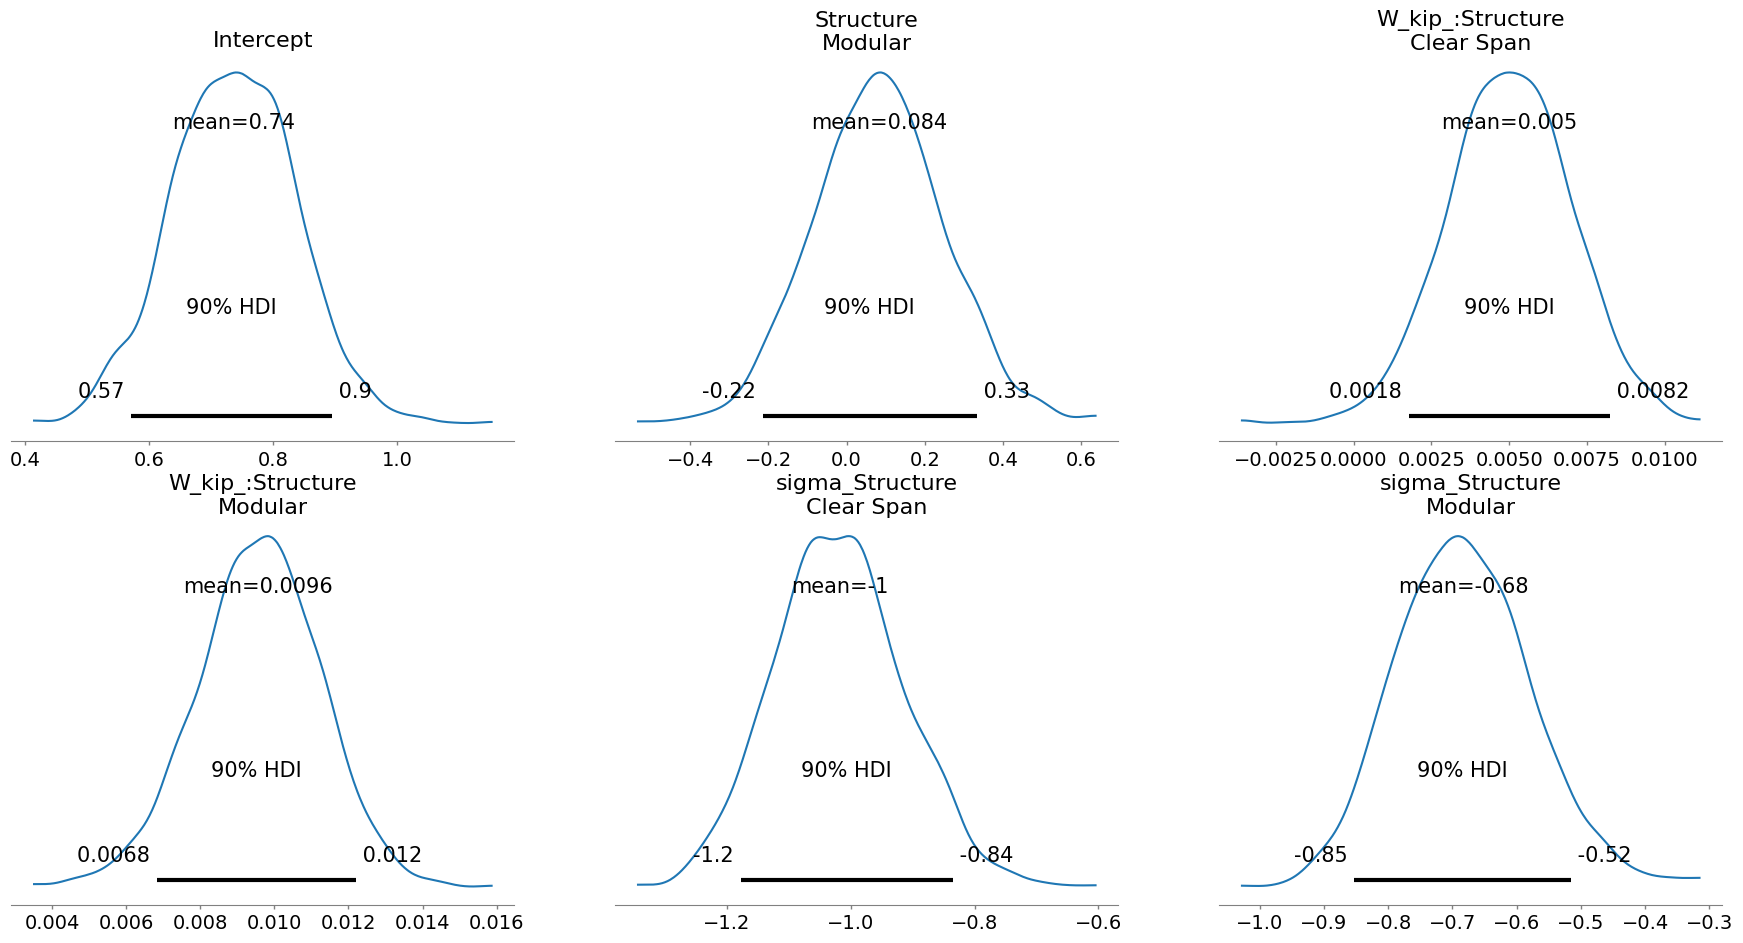

mean     sd  hdi_5%  hdi_95%  mcse_mean  \
Intercept                     0.736  0.099   0.571    0.896      0.002   
Structure[Modular]            0.084  0.168  -0.215    0.334      0.005   
W_kip_:Structure[Clear Span]  0.005  0.002   0.002    0.008      0.000   
W_kip_:Structure[Modular]     0.010  0.002   0.007    0.012      0.000   
sigma_Structure[Clear Span]  -1.018  0.105  -1.178   -0.835      0.002   
sigma_Structure[Modular]     -0.683  0.105  -0.853   -0.516      0.002   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                       0.002    2045.0    1459.0    1.0  
Structure[Modular]              0.003    1277.0    1353.0    1.0  
W_kip_:Structure[Clear Span]    0.000    2245.0    1414.0    1.0  
W_kip_:Structure[Modular]       0.000    1701.0    1242.0    1.0  
sigma_Structure[Clear Span]     0.002    2090.0    1147.0    1.0  
sigma_Structure[Modular]        0.002    2042.0    1508.0    1.0

In [ ]:
az.plot_posterior(results5,var_names=['Intercept','Structure','W_kip_:Structure','sigma_Structure'], hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results5,var_names=['Intercept','Structure','W_kip_:Structure','sigma_Structure'],hdi_prob=0.9)

In [ ]:
# Hacer predicciones con mi modelo
model5.predict(results5,kind='pps')

results5

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

#### Estudio del modelo

Veamos si realmente el desvío estandar es distinto para cada categoría (para este modelo).

NOTA: Nosostros ajustamos el logaritmo del desvío (es cómo trabaja `Bambi` cuando se le incluye una función a `sigma`), por lo que hay transformarlo a escala lineal primero si queremos.

Noten que para *este modelo* la diferencia en la ordenada al origen es nula! Pero, qué me dicen de la pendiente?

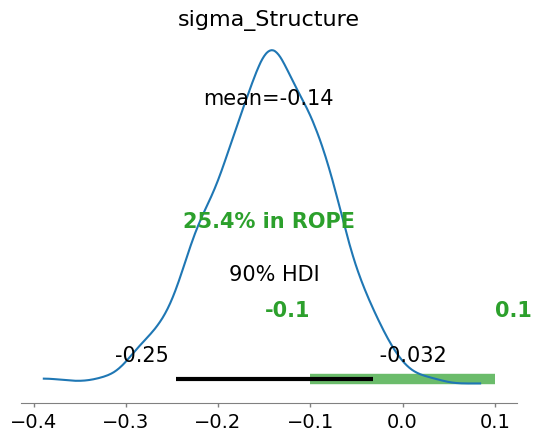

In [ ]:
Rdiff = np.exp(results5.posterior['sigma_Structure'][:,:,0]) - np.exp(results5.posterior['sigma_Structure'][:,:,1])

# Resumen de la inferencia
az.plot_posterior(Rdiff,hdi_prob=0.9,rope=[-0.1,0.1])
plt.show()

Según el ROPE puede que sean similares a fines prácticos, aunque es efectivamente significativamente distinta de 0 la diferencia.

#### Visualización

Veamos nuevamente como ver los resultados de mi modelo con `Bambi`. Esto se puede hacer con la función `bmb.interpret.plot_predictions`. Para ello, una opción es setar 2 condicionales. Para ello utilizamos la variable `subplot_kwargs` donde se incluye como diccionario.

- `main`: la condición que vamos a graficar (en nuestro caso, en función de la altura)
- `panel`: las condiciones para las cuales vamos a generar distintos gráficos (en nuestro caso, la categoría sexo)

Los invitamos a ver la documentación de Bambi para más formas de presentar los datos!

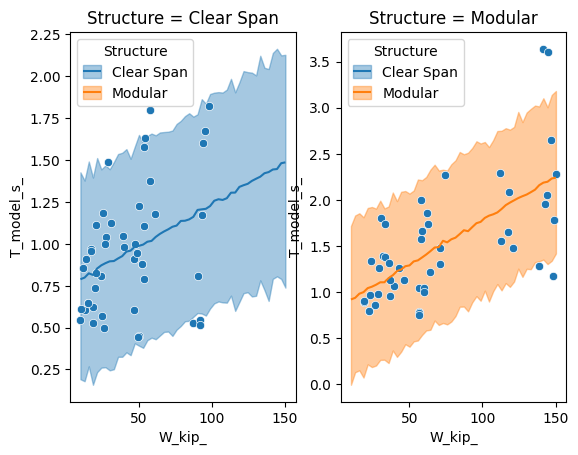

In [ ]:
fig, ax = bmb.interpret.plot_predictions(model5,results5,['W_kip_','Structure'],subplot_kwargs={'main':'W_kip_','panel':'Structure'},pps=True,prob=0.9)
sns.scatterplot(x='W_kip_', y='T_model_s_',data=df[(df['Cladding']=='Metal Panels')&(df['Structure']=='Clear Span')],ax=ax[0])
sns.scatterplot(x='W_kip_', y='T_model_s_',data=df[(df['Cladding']=='Metal Panels')&(df['Structure']=='Modular')],ax=ax[1])
plt.show()

¿Se acuerdan que ustedes podían setear manualmente las condiciones? Esto es muy útil especialmente para el caso de variables categóricas. Así puedo elegir yo qué quiero mirar (y se va a ver mucho mejor).



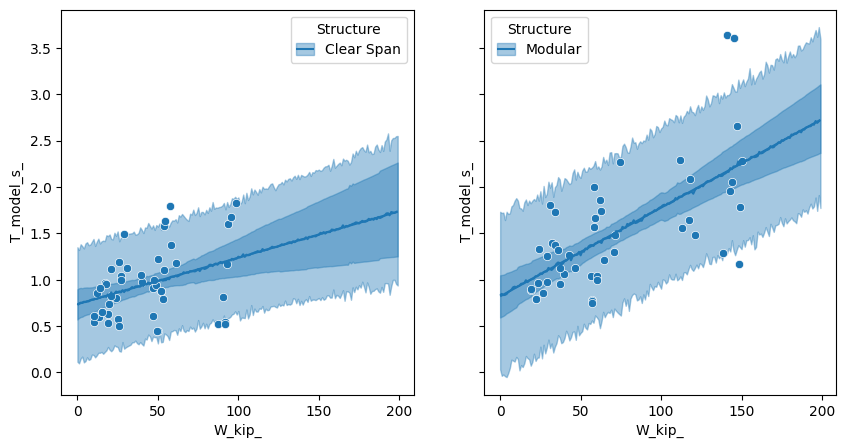

In [ ]:
fig, (axs) = plt.subplots(1, 2,figsize=(10,5),sharey=True)

bmb.interpret.plot_predictions(model5,results5,conditional={'W_kip_':np.array(range(200)),'Structure':'Clear Span'},ax=axs[0],pps=False,prob=0.9)
bmb.interpret.plot_predictions(model5,results5,conditional={'W_kip_':np.array(range(200)),'Structure':'Clear Span'},ax=axs[0],pps=True,prob=0.9)
sns.scatterplot(x='W_kip_', y='T_model_s_',data=df[(df['Cladding']=='Metal Panels')&(df['Structure']=='Clear Span')],ax=axs[0])

bmb.interpret.plot_predictions(model5,results5,conditional={'W_kip_':np.array(range(200)),'Structure':'Modular'},ax=axs[1],pps=False,prob=0.9)
bmb.interpret.plot_predictions(model5,results5,conditional={'W_kip_':np.array(range(200)),'Structure':'Modular'},ax=axs[1],pps=True,prob=0.9)
sns.scatterplot(x='W_kip_', y='T_model_s_',data=df[(df['Cladding']=='Metal Panels')&(df['Structure']=='Modular')],ax=axs[1])
plt.show()

Noten que se puede apreciar la diferencia en el desvío ente cada modelo!

### Modelo 6: Recta en escala logarítmica (Modelos generalizados)

Como dijimos antes, la función que afecta al valor medio no tiene por qué ser "una recta", puede tomar cualquier forma. Una opción muy común es considerar una recta logarítmica, es decir:

$$T|W \sim N(\mu = a\cdot W^{b},\sigma)$$

Este modelo es no-lineal en los parámetros, pero puede reescribirse si se trabaja sobre el logaritmo de $\mu$ (`link='log'` en vez de `identity`). Es decir:

$$T|W \sim N(\log \mu = c+ b\cdot \log W,\sigma)$$

donde $c=\log a$. Cargar esto en `Bambi` no difiere mucho de todos los modelos anteriores, ya que entiende qué significa tomar un logaritmo natural.

#### Construcción del modelo

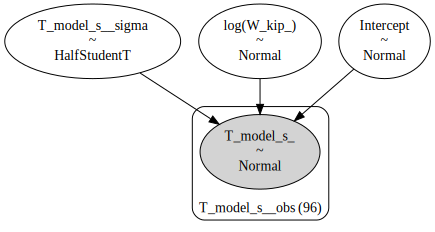

In [ ]:
# Modelo 6
model6 = bmb.Model("T_model_s_ ~ log(W_kip_)", df[df['Cladding']=='Metal Panels'], family='gaussian',link='log')

# Ver el modelo
model6.build()
model6.graph()

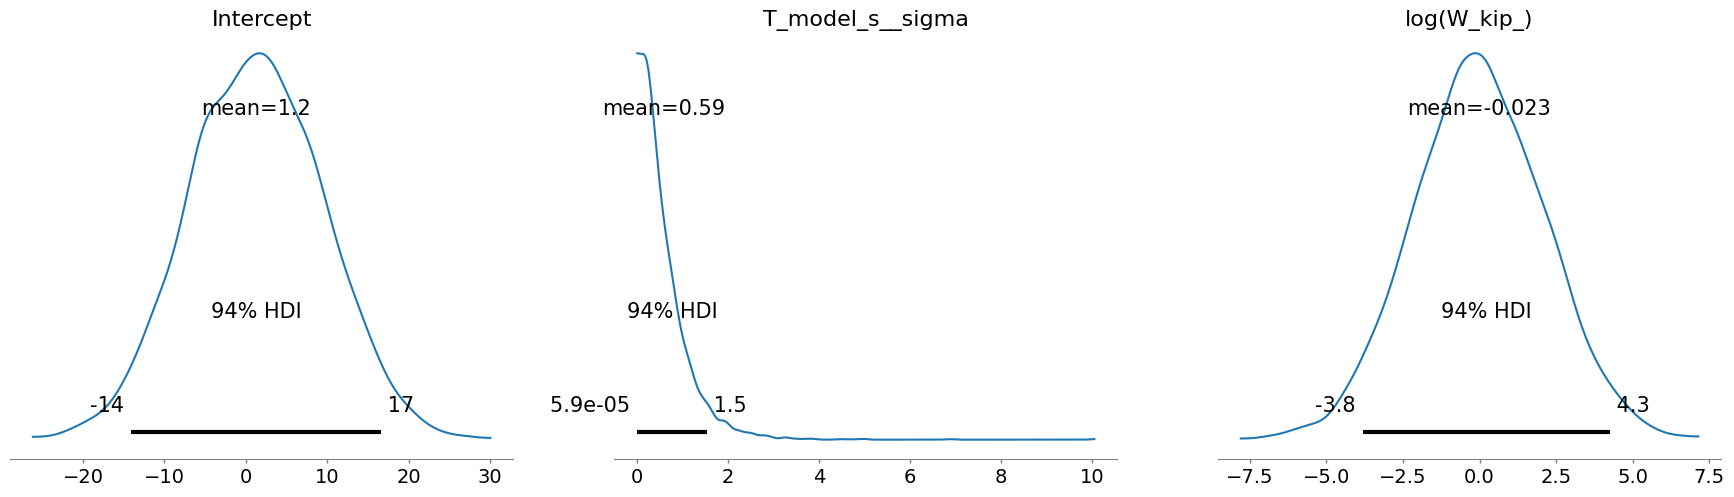

In [ ]:
# Grafico las distribuciones a priori
model6.plot_priors()
plt.show()

In [ ]:
# Hago la inferencia estadística
results6 = model6.fit(chains=2,draws=1000,tune=1000,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

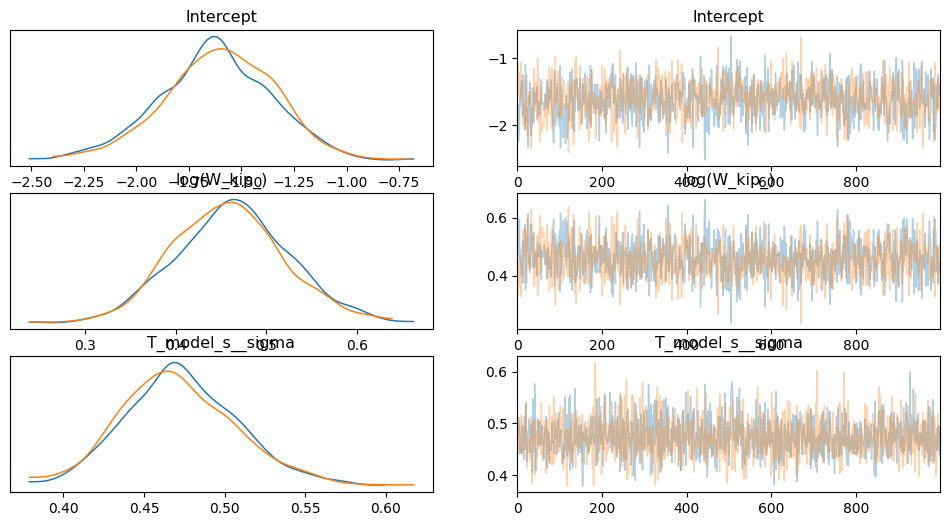

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept        -1.614  0.262  -2.115   -1.134      0.009    0.006     911.0   
log(W_kip_)       0.460  0.061   0.351    0.579      0.002    0.001     992.0   
T_model_s__sigma  0.473  0.036   0.407    0.543      0.001    0.001    1818.0   

                  ess_tail  r_hat  
Intercept           1537.0    1.0  
log(W_kip_)         1490.0    1.0  
T_model_s__sigma    1277.0    1.0

In [ ]:
# Diagnóstico de la Cadena
az.plot_trace(results6, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results6)

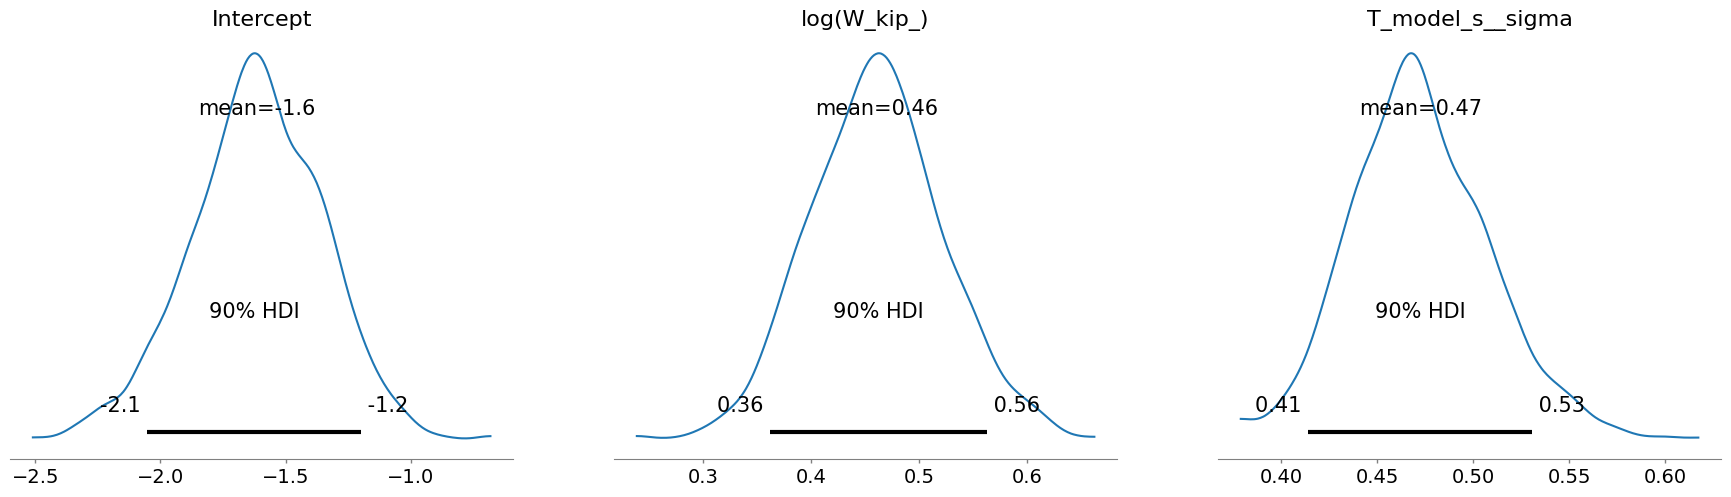

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
Intercept        -1.614  0.262  -2.055   -1.198      0.009    0.006     911.0   
log(W_kip_)       0.460  0.061   0.362    0.562      0.002    0.001     992.0   
T_model_s__sigma  0.473  0.036   0.414    0.530      0.001    0.001    1818.0   

                  ess_tail  r_hat  
Intercept           1537.0    1.0  
log(W_kip_)         1490.0    1.0  
T_model_s__sigma    1277.0    1.0

In [ ]:
az.plot_posterior(results6, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results6,hdi_prob=0.9)

In [ ]:
# Hacer predicciones con mi modelo
model6.predict(results6,kind='pps')

#### Visualización y evaluación de residuos

Bien, tenemos nuestro modelo "ajustado", y queremos ahora visualizar los datos. Ahora empieza a perder sentido graficar las curvas de densidad de probabilidad porque el valor medio es una función del peso y, como el peso es continuo, para cada valor tengo con suerte un dato para comparar.

Lo que se construye entonces en un gráfico que muestra la predicción y los intervalos de confianza, ya sea para el valor medio o para la predicción, de forma tal de poder ver fácilmente si los datos caen dentro de lo esperado.

Esto se puede hacer con la función `bmb.interpret.plot_predictions` de `Bambi`.En esta se incluye:
- El modelo
- Los resultados de la inferencia y predicciones
- Una lista con las variables con la cual condicionar el modelo
- pps: si queremos dibujar la incertidumbre del valor medio o de la predicción.
- el valor a tener en cuenta para el HDI

Después veremos que hay más opciones, pero con esto se empieza. El gráfico van a ver que muestra para cada valor de `W_kip_` la posterior predictiva para el valor medio y su incertidumbre (sea la del valor medio o la nueva observación).

Manualmente pueden agregarle a ese gráfico los datos observados para evaluar.

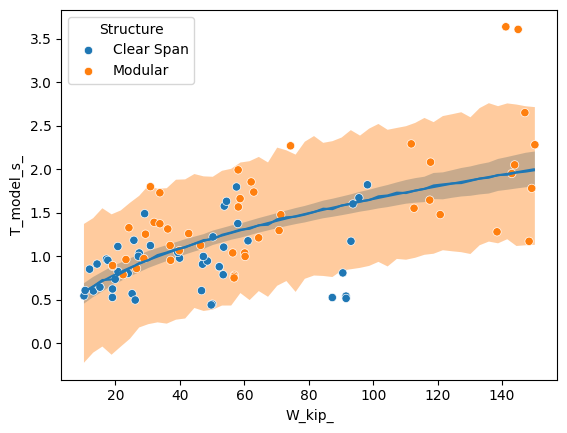

In [ ]:
fig, ax = bmb.interpret.plot_predictions(model6,results6,'W_kip_',pps=False,prob=0.9)
bmb.interpret.plot_predictions(model6,results6,'W_kip_',pps=True,prob=0.9,ax=ax)
sns.scatterplot(x='W_kip_', y='T_model_s_', hue='Structure',data=df[df['Cladding']=='Metal Panels'])
plt.show()

Además, ustedes pueden manualmente setear exactamente a qué valores (de, por ejemplo, peso) condicionar el gráfico. Esto es muy útil para ver cómo extrapola la función, o para analizar un caso particular.



/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


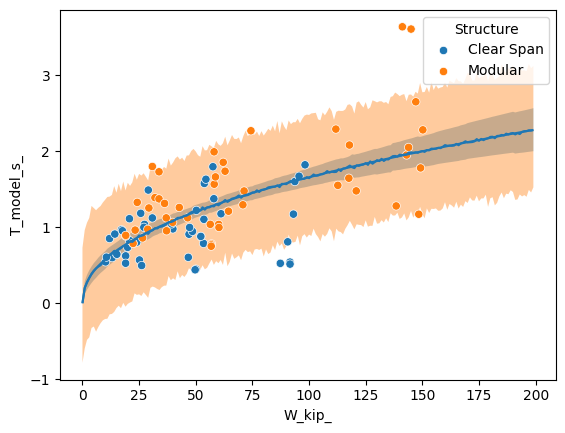

In [ ]:
fig, ax = bmb.interpret.plot_predictions(model6,results6,conditional={'W_kip_':np.array(range(200))},pps=False,prob=0.9)
bmb.interpret.plot_predictions(model6,results6,conditional={'W_kip_':np.array(range(200))},pps=True,prob=0.9,ax=ax)
sns.scatterplot(x='W_kip_', y='T_model_s_', hue='Structure',data=df[df['Cladding']=='Metal Panels'])
plt.show()

Otra cosa muy útil para hacer un diagnóstico del modelo es mirar los residuos. En el modelo que construimos dijimos que el desvío estandar era único y constante, por lo que los residuos deben estar centrados en 0 y con una dispersión constante para todo valor de `W_kip_` (o de `T_model_s`, como prefieran varlo).

Chequiemos primero la dsitrbución de los residuos (les dejamos el código escrito para que tengan)

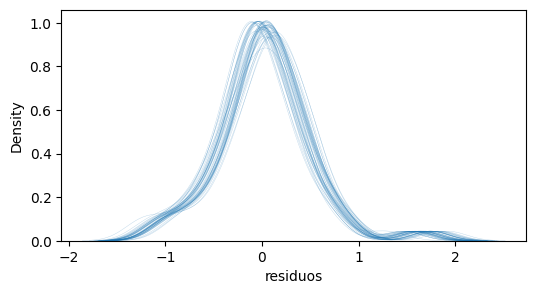

In [ ]:
y_obs = df[df['Cladding']=='Metal Panels']['T_model_s_']
fig, ax = plt.subplots( figsize=(6,3) )
for i in range(100,150):
  mu_pred = np.exp(results6.posterior["Intercept"].sel(chain=0,draw=i).values+\
  results6.posterior["log(W_kip_)"].sel(chain=0,draw=i).values * np.log(df[df['Cladding']=='Metal Panels'].W_kip_))
  residuals = y_obs - mu_pred
  sns.kdeplot( residuals, ax=ax, linewidth=.3, alpha=.3, color='C0' )

ax.set_xlabel('residuos')
plt.show()

Bien, los residuos parecen aproximadamente normales y centrados en 0 (podría hacer qq-plots, bpv, lo que querramos para testear). Pero... ¿depende la dispersión de las variables o su valor medio de las variables?

Veamoslo gráficamente (les dejamos el código)

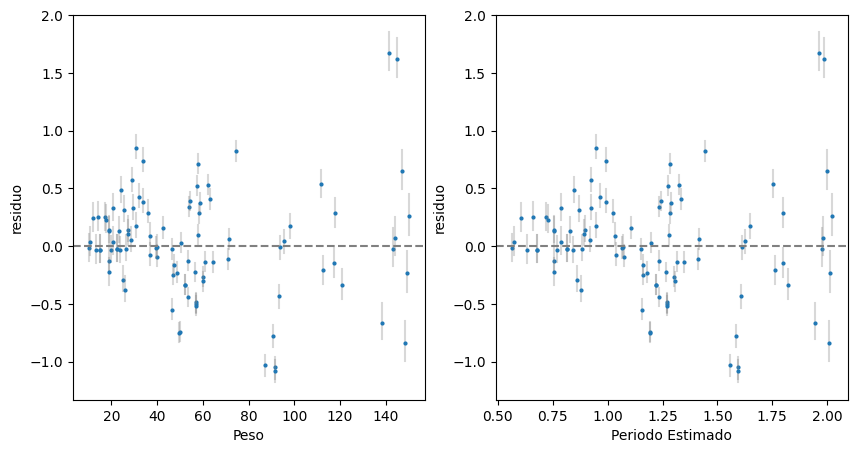

In [ ]:
y_obs = df[df['Cladding']=='Metal Panels']['T_model_s_'].to_numpy()

fig, (axs) = plt.subplots(1, 2,figsize=(10,5))

xx = df[df['Cladding']=='Metal Panels'].W_kip_.to_numpy()

for i in range(len(xx)):
  mu_pred = np.exp(results6.posterior["Intercept"].sel(chain=0,draw=slice(1,150)).values+\
  results6.posterior["log(W_kip_)"].sel(chain=0,draw=slice(1,150)).values * np.log(xx[i]))
  residuals = y_obs[i] - mu_pred
  quantiles = np.quantile(residuals, 0.05), np.quantile(residuals, 0.95)
  axs[0].plot( [xx[i],xx[i]], quantiles, color='gray', alpha=.3 )
  axs[0].plot( xx[i], residuals.mean(), 'o', color='C0', markersize=2)

  axs[1].plot( [mu_pred.mean(),mu_pred.mean()], quantiles, color='gray', alpha=.3 )
  axs[1].plot(mu_pred.mean(), residuals.mean(), 'o', color='C0', markersize=2)

axs[0].axhline( y=0, linestyle='--', color='gray', linewidth=1.5)
axs[0].set_ylabel('residuo')
axs[0].set_xlabel('Peso')

axs[1].axhline( y=0, linestyle='--', color='gray', linewidth=1.5)
axs[1].set_ylabel('residuo')
axs[1].set_xlabel('Periodo Estimado')
plt.show()

Notarán que los residuos están efectivamente centrados alrededor del 0 para todos los pesos (la formula lineal podría estar bien), pero que la dispersión va en aumento! Esto último me preocupa, porque quiere decir que no es constante el valor de $\sigma$ en los datos. El modelo Normal puede que no sea el mejor.

A su vez, el gráfico de la derecha me está diciendo que los residuos no son constantes con el período observado. En general, mi modelo predice demás en períodos cortos, y de menos en períodos largos. Tal vez el modelo no sea tan bueno...

### Modelo 7: Otras familias generadoras de datos (Modelo Log-Normal)

Nosotros hasta ahora siempre venimos utilizando modelos generadores de datos normales, y venimos cambiando (en general) el valor medio. Pero a mi nada me impide hacer un modelo condicionado con otra familia! Por ejemplo, la lognormal.

Una forma de hacerlo es considerando que, si $T$ es lognormal, entonces $\log T$ es normal.

$$\log T|W \sim N(\mu = c+b\cdot \log W,\sigma)$$

Otra opción es directamente escribir el modelo lognormal!

$$T|W \sim LN(\mu = c+b\cdot \log W,\sigma)$$

A modo de ejemplo, vamos a hacer esto último en `Bambi`.

Nota: En los modelos log-normales se suele tomar como "posterior predictiva" a la mediana ($e^{\mu}$) en vez de a la media ($e^{\mu+\sigma^{2}/2}$). Eso es porque se lo suele trabajar en escala logarítmica y luego se vuelve.

#### Construcción del modelo

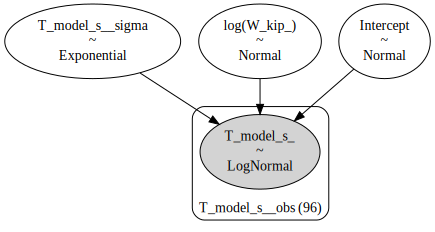

In [ ]:
# Modelo 7
# Construct likelihood distribution ------------------------------
# This must use a valid PyMC distribution name.
# 'parent' is the name of the variable that represents the mean of the distribution.
likelihood = bmb.Likelihood("LogNormal", params=["mu", "sigma"], parent="mu")

# Set link function ----------------------------------------------
# 1. Pass a name that is known by Bambi
link = {"mu": "identity"}

# Construct the family -------------------------------------------
# Families are defined by a name, a Likelihood and a Link.
family = bmb.Family("lognormal", likelihood, link)

# Choose Priors (necessary for custom families) ------------------
priors = {"Intercept": bmb.Prior("Normal",mu=0,sigma=10),
          "log(W_kip_)": bmb.Prior("Normal",mu=0.5,sigma=0.2),
  "sigma": bmb.Prior("Exponential", lam=1/10)}


model7 = bmb.Model("T_model_s_ ~ log(W_kip_)", df[df['Cladding']=='Metal Panels'], family=family,link=link,priors=priors)

# Ver el modelo
model7.build()
model7.graph()

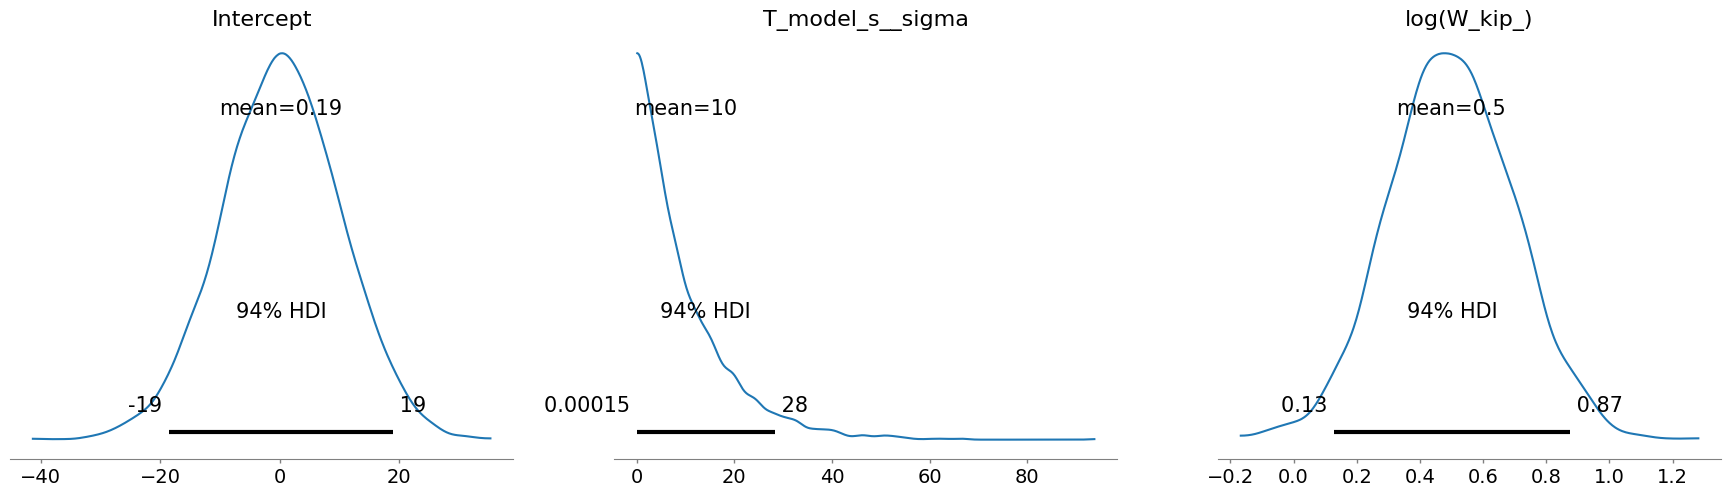

In [ ]:
# Grafico las distribuciones a priori
model7.plot_priors()
plt.show()

In [ ]:
# Hago la inferencia estadística
results7 = model7.fit(chains=2,draws=1000,tune=1000,
                                    idata_kwargs={"log_likelihood": True},nuts={"target_accept":0.8})

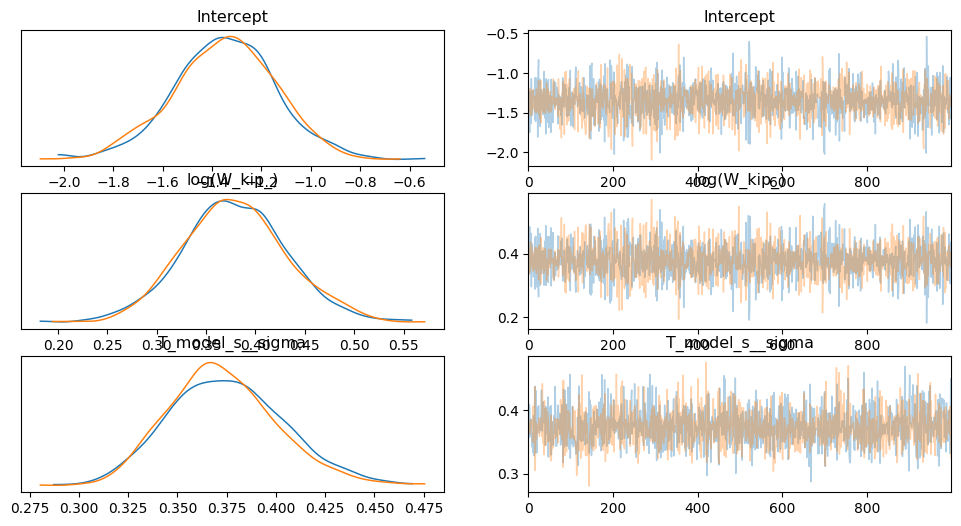

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept        -1.348  0.208  -1.757   -0.961      0.004    0.003    2590.0   
log(W_kip_)       0.379  0.054   0.279    0.483      0.001    0.001    2688.0   
T_model_s__sigma  0.374  0.029   0.324    0.431      0.001    0.000    2318.0   

                  ess_tail  r_hat  
Intercept           1679.0    1.0  
log(W_kip_)         1559.0    1.0  
T_model_s__sigma    1512.0    1.0

In [ ]:
# Diagnóstico de la Cadena
az.plot_trace(results7, compact=False);
plt.show()

# Resumen de la inferencia
az.summary(results7)

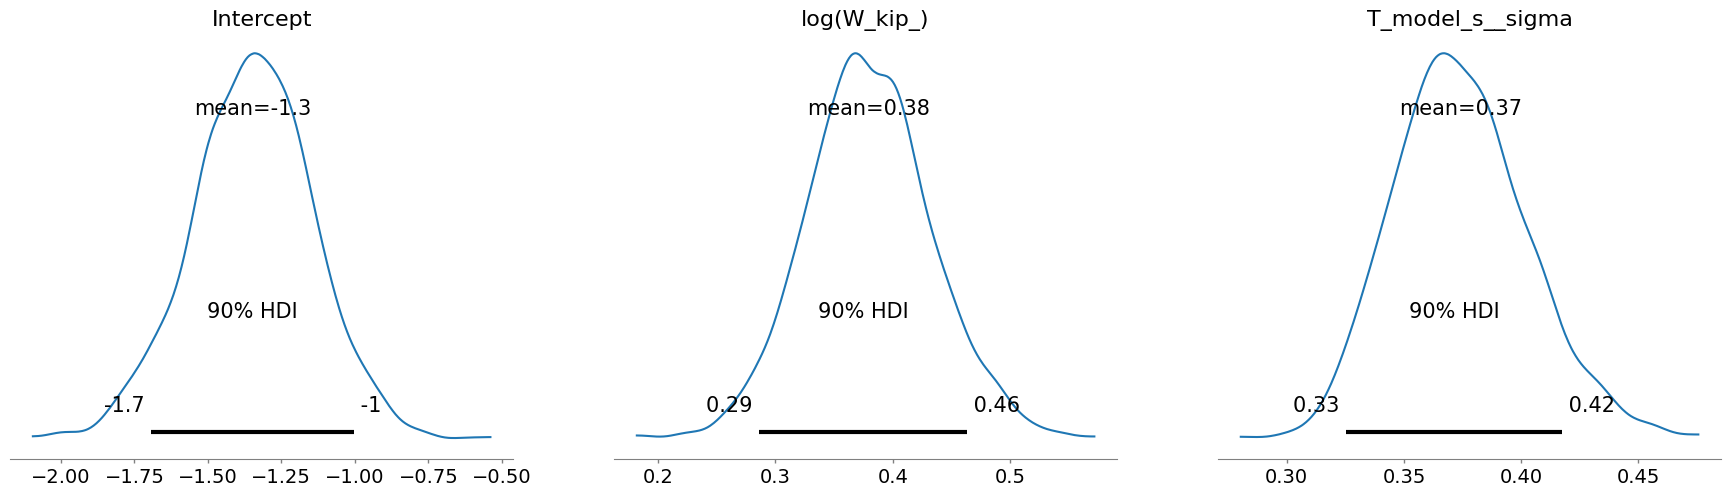

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
Intercept        -1.348  0.208  -1.693   -1.003      0.004    0.003    2590.0   
log(W_kip_)       0.379  0.054   0.286    0.463      0.001    0.001    2688.0   
T_model_s__sigma  0.374  0.029   0.325    0.418      0.001    0.000    2318.0   

                  ess_tail  r_hat  
Intercept           1679.0    1.0  
log(W_kip_)         1559.0    1.0  
T_model_s__sigma    1512.0    1.0

In [ ]:
az.plot_posterior(results7, hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results7,hdi_prob=0.9)

In [ ]:
# Hacer predicciones con mi modelo
model7.predict(results7,kind='pps')

results7

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

#### Visualización y evaluación de residuos

Bien, tenemos nuestro modelo "ajustado", y queremos ahora visualizar los datos. Ahora empieza a perder sentido graficar las curvas de densidad de probabilidad porque el valor medio es una función del peso y, como el peso es continuo, para cada valor tengo con suerte un dato para comparar.

Lo que se construye entonces en un gráfico que muestra la predicción y los intervalos de confianza, ya sea para el valor medio o para la predicción, de forma tal de poder ver fácilmente si los datos caen dentro de lo esperado.

Esto se puede hacer con la función `bmb.interpret.plot_predictions` de `Bambi`.En esta se incluye:
- El modelo
- Los resultados de la inferencia y predicciones
- Una lista con las variables con la cual condicionar el modelo
- pps: si queremos dibujar la incertidumbre del valor medio o de la predicción.
- el valor a tener en cuenta para el HDI

Después veremos que hay más opciones, pero con esto se empieza. El gráfico van a ver que muestra para cada valor de `W_kip_` la posterior predictiva para el valor medio y su incertidumbre (sea la del valor medio o la nueva observación).

Manualmente pueden agregarle a ese gráfico los datos observados para evaluar.

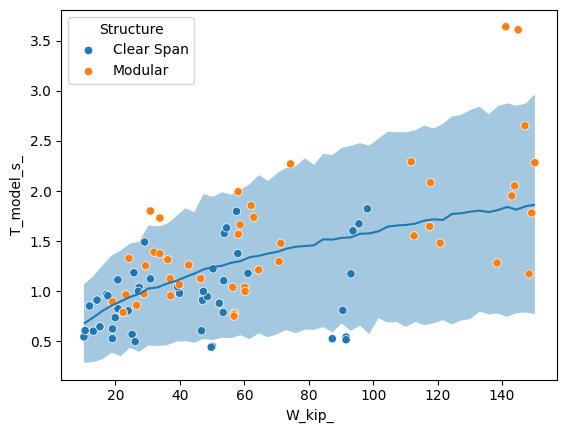

In [ ]:
fig, ax = bmb.interpret.plot_predictions(model7,results7,'W_kip_',pps=True,prob=0.9)
sns.scatterplot(x='W_kip_', y='T_model_s_', hue='Structure',data=df[df['Cladding']=='Metal Panels'])
plt.show()

Noten como la dispersión aumenta a medida que aumenta `W_kip_`. Eso es porque los modelos lognormales mantienen constante el coeficiente de varación (error relativo) en vez del desvío (error absoluto).

Además, ustedes pueden manualmente setear exactamente a qué valores (de, por ejemplo, peso) condicionar el gráfico. Esto es muy útil para ver cómo extrapola la función, o para analizar un caso particular.



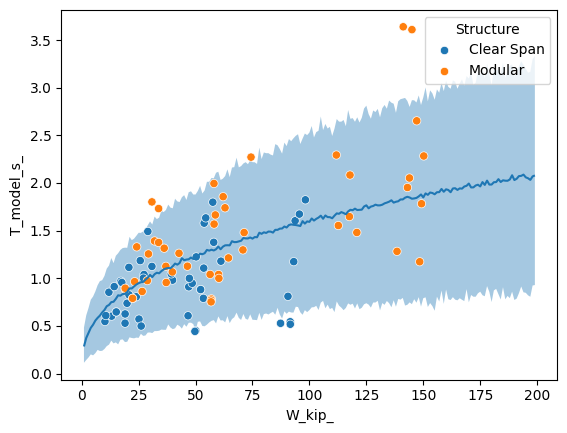

In [ ]:
fig, ax = bmb.interpret.plot_predictions(model7,results7,conditional={'W_kip_':np.array(range(1,200))},pps=True,prob=0.9)
sns.scatterplot(x='W_kip_', y='T_model_s_', hue='Structure',data=df[df['Cladding']=='Metal Panels'])
plt.show()

NOTA: El modelo está graficando al promedio como la predictiva. En modelos log-normales se suele tomar la mediana, como dijimos antes.

Otra cosa muy útil para hacer un diagnóstico del modelo es mirar los residuos. El modelo que construimos era log-normal. En estos modelos hay dos formas de hacer el analisis de residuos.

Una opción es hacerlo sobre el logaritmo:

$$r = \log y_{obs}-\log \hat{y} = \log y_{obs} - \mu$$

En este caso lo que vamos a mirar es que los residuos sean normales con valor medio 0 y desvío constante

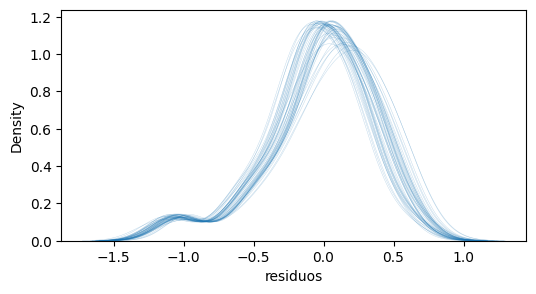

In [ ]:
y_obs = df[df['Cladding']=='Metal Panels']['T_model_s_']
fig, ax = plt.subplots( figsize=(6,3) )
for i in range(100,150):
  mu_pred = np.exp(results6.posterior["Intercept"].sel(chain=0,draw=i).values+\
  results6.posterior["log(W_kip_)"].sel(chain=0,draw=i).values * np.log(df[df['Cladding']=='Metal Panels'].W_kip_))
  residuals = np.log(y_obs) - np.log(mu_pred)
  sns.kdeplot( residuals, ax=ax, linewidth=.3, alpha=.3, color='C0' )

ax.set_xlabel('residuos')
plt.show()

Bien, los residuos parecen aproximadamente normales y centrados en 0 (podría hacer qq-plots, bpv, lo que querramos para testear). Pero... ¿depende la dispersión de las variables o su valor medio de las variables?

Veamoslo gráficamente (les dejamos el código)

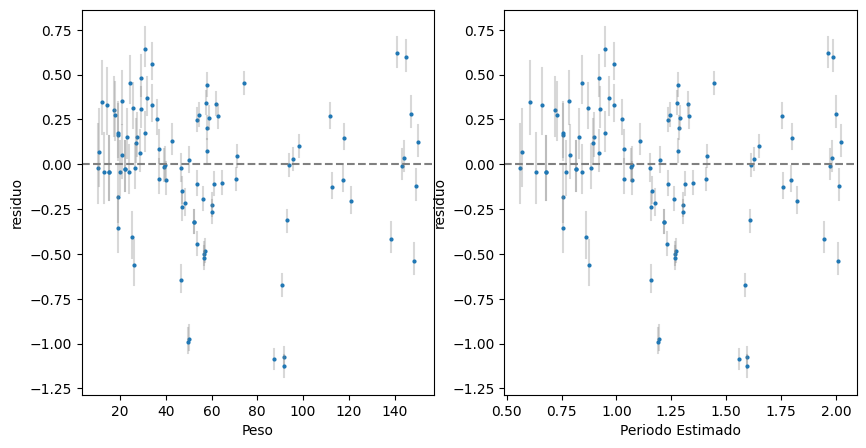

In [ ]:
y_obs = df[df['Cladding']=='Metal Panels']['T_model_s_'].to_numpy()

fig, (axs) = plt.subplots(1, 2,figsize=(10,5))

xx = df[df['Cladding']=='Metal Panels'].W_kip_.to_numpy()

for i in range(len(xx)):
  mu_pred = np.exp(results6.posterior["Intercept"].sel(chain=0,draw=slice(1,150)).values+\
  results6.posterior["log(W_kip_)"].sel(chain=0,draw=slice(1,150)).values * np.log(xx[i]))
  residuals = np.log(y_obs[i]) - np.log(mu_pred)
  quantiles = np.quantile(residuals, 0.05), np.quantile(residuals, 0.95)
  axs[0].plot( [xx[i],xx[i]], quantiles, color='gray', alpha=.3 )
  axs[0].plot( xx[i], residuals.mean(), 'o', color='C0', markersize=2)

  axs[1].plot( [mu_pred.mean(),mu_pred.mean()], quantiles, color='gray', alpha=.3 )
  axs[1].plot( mu_pred.mean(), residuals.mean(), 'o', color='C0', markersize=2)

axs[0].axhline( y=0, linestyle='--', color='gray', linewidth=1.5)
axs[0].set_ylabel('residuo')
axs[0].set_xlabel('Peso')

axs[1].axhline( y=0, linestyle='--', color='gray', linewidth=1.5)
axs[1].set_ylabel('residuo')
axs[1].set_xlabel('Periodo Estimado')
plt.show()

Notarán que los residuos están efectivamente centrados alrededor del 0 con desvío constante (en el logarítmo), que quiere decir que en la escala completa el desvío crece linealmente con el período estimado (como vimos en el modelo 6).

La otra forma de pensar el problema es que:

$$r = \frac{y_{obs}}{\hat{y}}=\frac{y_{obs}}{e^{\mu}}$$

(una medida muy similar al coeficiente de variación) sigue una Log-normal LN(0,1). Es decir, está centrada en 1 con dispersión constante (por ejemplo multiplicar y dividir por 2 al centro de valor 1). Esto es así porque $\log r$ es una N(0,1) (son los residuos del logaritmo, como hicimos arriba).

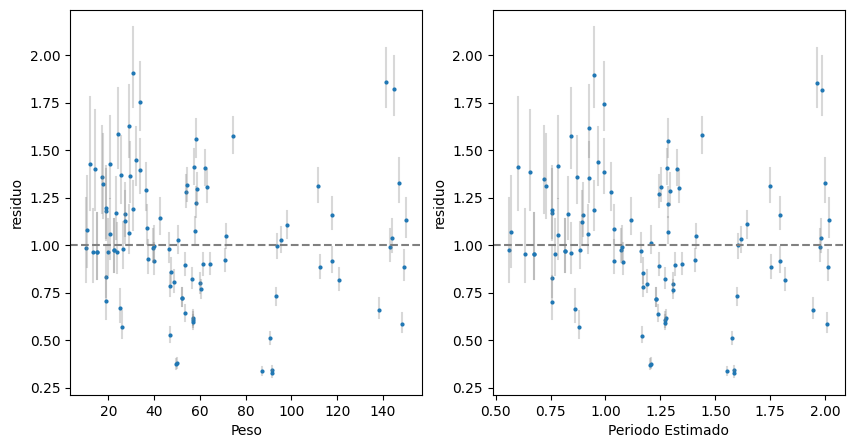

In [ ]:
y_obs = df[df['Cladding']=='Metal Panels']['T_model_s_'].to_numpy()

fig, (axs) = plt.subplots(1, 2,figsize=(10,5))

xx = df[df['Cladding']=='Metal Panels'].W_kip_.to_numpy()

for i in range(len(xx)):
  mu_pred = np.exp(results6.posterior["Intercept"].sel(chain=0,draw=slice(1,150)).values+\
  results6.posterior["log(W_kip_)"].sel(chain=0,draw=slice(1,150)).values * np.log(xx[i]))
  residuals = y_obs[i]/mu_pred
  quantiles = np.quantile(residuals, 0.05), np.quantile(residuals, 0.95)
  axs[0].plot( [xx[i],xx[i]], quantiles, color='gray', alpha=.3 )
  axs[0].plot( xx[i], residuals.mean(), 'o', color='C0', markersize=2)

  axs[1].plot( [np.median(mu_pred),np.median(mu_pred)], quantiles, color='gray', alpha=.3 )
  axs[1].plot( np.median(mu_pred), np.median(residuals), 'o', color='C0', markersize=2)

axs[0].axhline( y=1, linestyle='--', color='gray', linewidth=1.5)
axs[0].set_ylabel('residuo')
axs[0].set_xlabel('Peso')

axs[1].axhline( y=1, linestyle='--', color='gray', linewidth=1.5)
axs[1].set_ylabel('residuo')
axs[1].set_xlabel('Periodo Estimado')
plt.show()

### Selección de modelos (LOO-CV)

Hasta ahora hemos visto muchas formas de evaluar un modelo en sí mismo (bpv, qq-plots, posterior predictive check, residuos). Y aunque comparativamente podíamos ver si un modelo se parecía un poco más a los datos o tenía menos desvío en sus predicciones, no hemos realmente comparado modelos entre sí.

Lo que queremos para poder comparar y seleccionar modelos es tener alguna medida de la capacidad predictiva del modelo. Existen distintas formas de hacer esto (y las verán en la teórica). Hoy nos vamos a ocupar de una de ellas que es el Leave-One-Out Cross Validation.

La idea es la siguiente, si yo ajusto un modelo para todos los datos salvo uno, que tan bien puedo predicir ese dato que deje afuera (o, qué tan probable sería verlo con mi modelo? Y Si me hago esa preguntando para todos los datos de a uno por vez, tendría una buena medida de qué tan capaz es mi modelo de predecir datos que no vio.

El problema es que ajustar el modelo N-1 veces es muy costoso, pero existen métodos para estimar el resultado sin tener que volver a pasar por las cadenas de Markov. Esto es lo que se conoce como PSISLOO (Pareto Smoothed Importance Sampling Leave One Out Cross Validation).

Por suerte, correrlo se vuelve una línea de código! Para ello, al hacer la inferencia era importante guardar las log-verosimilitudes.

La comparación entre modelos se realiza con `az.compare`. Las principales variables son definir el tipo de criterio `loo` o `waic`, y la escala de los resutlados (por default es `log`, pueden elegir también `deviance`)

In [ ]:
# Diccionario con modelos a comparar
model_comp = {'Modelo 1':results1,'Modelo 2':results2,'Modelo 3':results3,\
              'Modelo 4':results4,'Modelo 5':results5,'Modelo 6':results6,\
              'Modelo 7':results7}

# Comparacion de modelos
az_comp_loo = az.compare( model_comp, ic='loo',scale='deviance')
az_comp_loo

rank    elpd_loo     p_loo  elpd_diff   weight         se  \
Modelo 7     0  105.249475  3.294877   0.000000  0.64271  17.086823   
Modelo 5     1  115.929716  7.449238  10.680241  0.00000  17.158390   
Modelo 4     2  120.005985  7.114118  14.756510  0.35729  19.849514   
Modelo 3     3  120.140720  5.757783  14.891245  0.00000  20.835871   
Modelo 2     4  128.413485  4.663402  23.164010  0.00000  20.614081   
Modelo 6     5  133.145014  5.170743  27.895540  0.00000  22.109387   
Modelo 1     6  157.170526  4.554378  51.921052  0.00000  24.927807   

                dse  warning     scale  
Modelo 7   0.000000    False  deviance  
Modelo 5  12.121938    False  deviance  
Modelo 4  15.250115    False  deviance  
Modelo 3  14.746461    False  deviance  
Modelo 2  12.043468    False  deviance  
Modelo 6  13.132444    False  deviance  
Modelo 1  21.619652    False  deviance

Los resultados son devueltos ya rankeados de mejor a peor! Así que el mejor modelo es el primero en la lista, el exponencial. Veamos que significan las columnas:

- elpd_loo: el resultado de, en este caso, la deviance (log-predictive density) estimada por PSIS-LOO-CV
- p_loo: se lo suele pensar como el número de parámetros efectivos del modelo. Idealmente daría algo menor al número de parámetros en tu modelo. Si da demás, podría indicar cierta incapacidad de predecir nuevos resultados.
- elpd_diff: Simplemente la diferencia entre los deviances. Existen criterios para decir cuándo una diferencia es importante (por ejemplo, hay trabajos que indican que un `elpd_diff` menor a 4 (8 en escala deviance) entonces la diferencia es pequeña entre los modelos)
- weight: da la idea de cómo combinar las distribuciones en una mezcla para mejorar la predicción. El valor con mayor peso sería el modelo "único" más adecuado.
- se: es el error en la estimación del `elpd`
- dse: es el error (aproximadamente el desvío estandar) en la estimación del `elpd_diff`.
- warning: indica si la estimación del LOO es buena o no. Si no lo es, habría que pasar a un k-fold cross validation tal vez (no siempre es necesario).

La idea sería la siguiente:
1. Ver si elpf_diff es mayor a 4 (8 en escala deviance). Si no lo es, la diferencia no es importante (en parte porque no se puede ajustar un modelo normal a las estimaciones).
2. Si lo es, comparar `elpd_diff` contra `dse` (asumiendo que tengo al menos 100 datos). Si este ratio es mayor a 1 (la diferencia es mayor a 1 desvíos estandar), entonces la diferencia es siginifactiva (algunos autores acá toman un valor de 2 o de 4 por que la estimación de `dse` es optimista)
2. Caso contrario, no puedo realmente distinguir entre los modelos (hay cierta arbirtrariedad acá, lo importante es informar los valores).

**NOTA**: 1 y 2. son en realidad criterios distintos, pero nuevas recomendaciones las combinan (El investigador principal de todo esto está muy activo en redes y tiene un FAQ!).

En nuestra experiencia en el curso y con la cantidad de datos que trabajamos, en general estamos en esta situación donde la diferencia nunca llega a ser significativa. En ese sentido siempre recomendamos agarrar el mejor modelo entre los modelos sencillos (de menor cantidad de parámetros), incorporando también conocimiento del proceso físico (si hay razones para pensar que los datos vienen de una lognormal, y no puedo justificar con los datos un modelo distinto, voy con esa!). O, si quieren, el que tenga mayor peso asignado podría ser también una forma.

¡Los resultados se pueden ver de forma gráfica también!

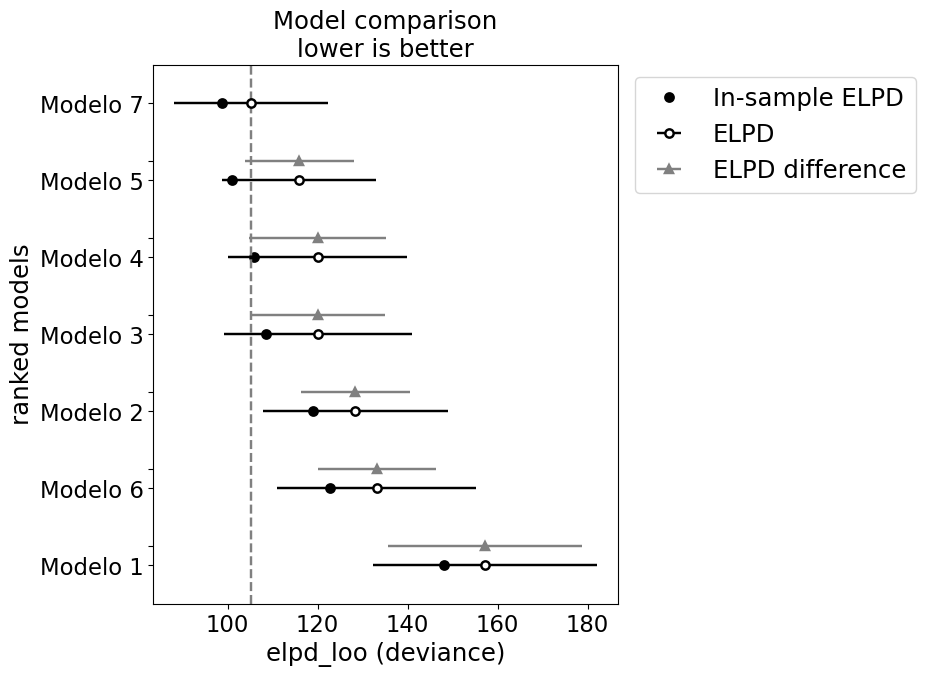

In [ ]:
az.plot_compare(az_comp_loo,insample_dev=True)
plt.show()

Noten que el punto negro es la capacidad predictiva de los datos vistos, mientras que el blanco la de los datos no vistos. Fijense que el modelo 5 (de 6 parámetros), tiene mayor diferencia entre los datos vistos y no vistos respecto de modelos más sencillos (como el modelo 7, de 3 parámetros). Esto es una señal de sobreajuste (demasiados parámetros para los datos que tengo).

Vean también que los triangulos muestran la diferencia entre capacidades predictivas con un más menos de 1 desvío estandar, como para ver gráficamente si puedo afirmar que un modelo es mejor que otro.

El resumen para este ejercicio, el mejor modelo es el simple modelo 7 lognormal!!! No había suficiente info para justificar muchos más parámetros como los del modelo 5.

NOTA: Obviamente, podría haber modelos mejores que este.

### Uso del Modelo para predicir datos no observados

Ahora tenemos nuestro mejor modelo, el modelo 7, que  no incluye efectos de la tipología estructural.

¿Cómo lo podemos usar para estimar el período de una nueva estructura?

Para ello construyamos un dataframe de "datos nuevos".

W_kip_	Height_in_	L_ft_	alpha	Cladding	Structure	Roof	Snow_psf	Seismic	Wind

In [ ]:
pd_new = pd.DataFrame({'W_kip_':[9.7],'Height_in':[21*12],'L_ft_':[60],'alpha':[2.86],\
                       'Cladding':['Metal Panels'],'Structure':['Clear Span'],\
                       'Roof':['Monoslope'],'Snow_psf':[0],'Seismic':['Low'],'Wind':['Low']})
pd_new

W_kip_  Height_in  L_ft_  alpha      Cladding   Structure       Roof  \
0     9.7        252     60   2.86  Metal Panels  Clear Span  Monoslope   

   Snow_psf Seismic Wind  
0         0     Low  Low

Nota: Anoté todos los datos por si ganaba un modelo que los requería.

Recordemos un poco cómo es nuestro modelo:

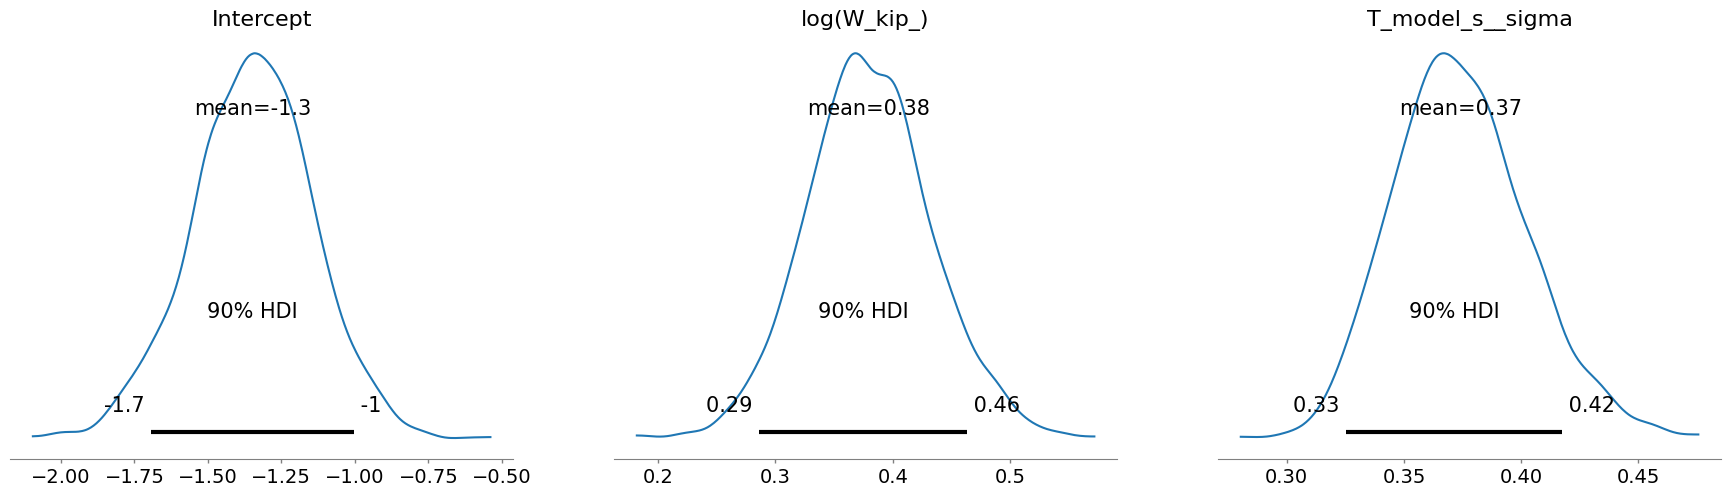

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
Intercept        -1.348  0.208  -1.693   -1.003      0.004    0.003    2590.0   
log(W_kip_)       0.379  0.054   0.286    0.463      0.001    0.001    2688.0   
T_model_s__sigma  0.374  0.029   0.325    0.418      0.001    0.000    2318.0   

                  ess_tail  r_hat  
Intercept           1679.0    1.0  
log(W_kip_)         1559.0    1.0  
T_model_s__sigma    1512.0    1.0

In [ ]:
az.plot_posterior(results7,var_names=['Intercept','log(W_kip_)','T_model_s__sigma'], hdi_prob=0.9)
plt.show()

# Resumen de la inferencia
az.summary(results7,var_names=['Intercept','log(W_kip_)','T_model_s__sigma'],hdi_prob=0.9)

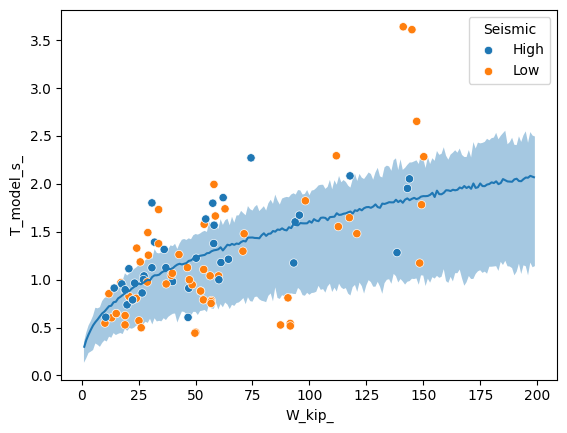

In [ ]:
fig, ax = bmb.interpret.plot_predictions(model7,results7,conditional={'W_kip_':np.array(range(1,200))},pps=True,prob=0.68)
sns.scatterplot(x='W_kip_', y='T_model_s_', hue='Seismic',data=df[df['Cladding']=='Metal Panels'])
plt.show()

Para obtener por simulación una predicción para datos no vistos (con sus variables explicativas), hacemos uso nuevamente de `predict`.



Para predecir este nuevo dato, simplemente usamos la función `predict` del modelo! Pero sí agregamos algunas variables más:

- `data`: los datos a predecir (ya no son los mismos datos que observé, sino mi nuevo dataframe
- `inplace=False` para no sobreescribir mi variable results3, sino crear una nueva! (importante!)
- `kind=pps` para que obtenga no solo la posterior del valor medio para estos nuevos datos sino también la posterior predictiva

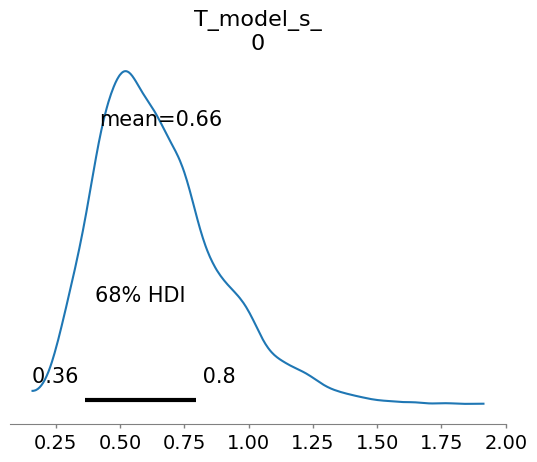

In [ ]:
# Prediccion de datos no observados
new_results7 = model7.predict(results7,data=pd_new,inplace=False,kind="pps")

# Una visualización de ejemplo
az.plot_posterior(new_results7.posterior_predictive['T_model_s_'],hdi_prob=0.68)
plt.show()

**NOTA**: Arriba mostramos el Intervalo de Confianza para el período dado los datos de mi edificio en forma directa porque el dataframe tenía un valor. Pero con esto pueden hacer lo que quieran, tienen los datos en `new_results3` con todas las simulaciones para cada persona de su valor medio, su desvío y su realización.

Recuerden que siempre pueden acceder a los datos y trabajarlos como prefieran!

Por ejemplo, para edificios se suele definir un límite inferior del período como aquel que tiene una probabilidad de ser superado del 84%. Veamos entonces, cuál es mi período de diseño!

In [ ]:
T_dis = np.quantile(np.ravel(new_results7.posterior_predictive['T_model_s_']),0.16)
print('El período de diseño es', T_dis,'segundos')


El período de diseño es 0.4243087659695596 segundos


NOTA: Este modelo es bastante malo (cociente entre límite superior e inferior mayor a 2, cuando el peor reglamentario es 1.6). Habría que seguir mejorandolo. Quién dice, capaz hacerlo fue un doctorado y una tesis de maestría en su momento.